# T1Dexi Data Processing Analysis

We need to make some small changes / exploration: 
- Why are the dates in 2031? Are we correctly getting local date time? 
   - Check time of day for different meal labels
   - Check blood glucose patterns throughout the day
   - If necessary, count meals for different times of day
- Go deeper into understanding whether the insulin doses and basal rates are processed correctly
- Do the same for other data types (meals, carbs, heartrate, exercise...)
- Insulin type information?



For each table, go through: 
- Datetimes 
- Values
- Time zone analysis
- Possible assumptions




In [79]:
import os
import subprocess
import zipfile
import zipfile_deflate64
import datetime
import random
import isodate
import xport
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

In [2]:
!pip install zipfile-deflate64


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [102]:
!pip install isodate


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Inspect zip file
zip_path = 'data/raw/t1dexi/T1DEXI.zip'
import zipfile
import os

# Check if the file exists
if not os.path.exists(zip_path):
    print(f"Error: File '{zip_path}' does not exist.")
else:
    print(f"Inspecting contents of '{zip_path}'...")

    # Open the .zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        # List all files in the .zip archive
        file_list = zip_file.namelist()
        print("Files in the .zip archive:")
        for file_name in file_list:
            print(f"- {file_name}")

Inspecting contents of 'data/raw/t1dexi/T1DEXI.zip'...
Files in the .zip archive:
- T1DEXI - DATA FOR UPLOAD/CM.xpt
- T1DEXI - DATA FOR UPLOAD/defineXML.html
- T1DEXI - DATA FOR UPLOAD/DI.xpt
- T1DEXI - DATA FOR UPLOAD/DM.xpt
- T1DEXI - DATA FOR UPLOAD/DX.xpt
- T1DEXI - DATA FOR UPLOAD/FA.xpt
- T1DEXI - DATA FOR UPLOAD/FACM.xpt
- T1DEXI - DATA FOR UPLOAD/FADX.xpt
- T1DEXI - DATA FOR UPLOAD/FAMLPD.xpt
- T1DEXI - DATA FOR UPLOAD/FAMLPI.xpt
- T1DEXI - DATA FOR UPLOAD/FAMLPM.xpt
- T1DEXI - DATA FOR UPLOAD/LB.xpt
- T1DEXI - DATA FOR UPLOAD/ML.xpt
- T1DEXI - DATA FOR UPLOAD/NV.xpt
- T1DEXI - DATA FOR UPLOAD/PR.xpt
- T1DEXI - DATA FOR UPLOAD/QS.xpt
- T1DEXI - DATA FOR UPLOAD/README.txt
- T1DEXI - DATA FOR UPLOAD/RP.xpt
- T1DEXI - DATA FOR UPLOAD/SC.xpt
- T1DEXI - DATA FOR UPLOAD/SUPPDM.xpt
- T1DEXI - DATA FOR UPLOAD/T1DEXI ACRF_15Sept2022.pdf
- T1DEXI - DATA FOR UPLOAD/T1DEXI SDRG_03Mar2023.pdf
- T1DEXI - DATA FOR UPLOAD/TI DEXI Protocol 8-25-20_V6.0.pdf
- T1DEXI - DATA FOR UPLOAD/VS.xpt


In [228]:
def save_files_from_zip(zip_path, file_types=['.pdf', '.html']):    
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        # Find files in the zip archive that match the specified types (pdf or html)
        matched_files = [f for f in zip_file.namelist() if any(f.endswith(ext) for ext in file_types)]
        
        if not matched_files:
            raise FileNotFoundError(f"No files with extensions {file_types} found in the zip archive.")
        
        # Loop through the matched files and save them locally
        for matched_file in matched_files:
            local_file_path = os.path.basename(matched_file)
            
            # Save the file to the output directory
            with zip_file.open(matched_file) as extracted_file:
                with open(local_file_path, 'wb') as local_file:
                    local_file.write(extracted_file.read())
                    print(f"Saved {matched_file} to {local_file_path}")
save_files_from_zip(zip_path, file_types=['.pdf', '.html', '.txt'])


Saved T1DEXI - DATA FOR UPLOAD/defineXML.html to defineXML.html
Saved T1DEXI - DATA FOR UPLOAD/README.txt to README.txt
Saved T1DEXI - DATA FOR UPLOAD/T1DEXI ACRF_15Sept2022.pdf to T1DEXI ACRF_15Sept2022.pdf
Saved T1DEXI - DATA FOR UPLOAD/T1DEXI SDRG_03Mar2023.pdf to T1DEXI SDRG_03Mar2023.pdf
Saved T1DEXI - DATA FOR UPLOAD/TI DEXI Protocol 8-25-20_V6.0.pdf to TI DEXI Protocol 8-25-20_V6.0.pdf


In [4]:
def get_df_from_zip_deflate_64(zip_path, file_name):
    with zipfile_deflate64.ZipFile(zip_path, 'r') as zip_file:
        # Find the file in the archive that ends with the specified file_name
        matched_files = [f for f in zip_file.namelist() if f.endswith(file_name)]
        if not matched_files:
            raise FileNotFoundError(f"No file ending with '{file_name}' found in the zip archive.")
        
        # Use the first match (if multiple matches, refine criteria as needed)
        matched_file = matched_files[0]

        # Read the .xpt file directly from the zip
        with zip_file.open(matched_file) as xpt_file:
            df = xport.to_dataframe(xpt_file)  # Load the .xpt file into a DataFrame
    return df


In [5]:
def print_unique_vals(df, max_vals=5):
    for col in df.columns:
        unique_values = df[col].dropna().unique()  # Get first 5 unique values, ignoring NaNs
        print(f"{col}: {unique_values[:max_vals]}, total unique values: {len(unique_values)}")


In [6]:
def create_sas_date_for_column(df, date_col):
    sas_epoch = datetime.datetime(1960, 1, 1)
    df[date_col] = pd.to_datetime(df[date_col], unit='s', origin=sas_epoch)
    return df


In [7]:
glucose_file = 'LB.xpt'

In [8]:
df_glucose = get_df_from_zip_deflate_64(zip_path, glucose_file)

In [9]:
df_glucose.head()

,STUDYID,DOMAIN,USUBJID,LBSEQ,LBTESTCD,LBTEST,LBCAT,LBORRES,LBORRESU,LBSTRESC,LBSTRESN,LBSTRESU,LBDTC,LBSOURCE,LBCRNORD,LBSETTNG,LBTMINT
0,T1DEXI,LB,1,1.0,GLUC,Glucose,CGM,115.0,mg/dL,115,115.0,mg/dL,1.904774e+09,,,,
1,T1DEXI,LB,1,2.0,GLUC,Glucose,CGM,109.0,mg/dL,109,109.0,mg/dL,1.904775e+09,,,,
2,T1DEXI,LB,1,3.0,GLUC,Glucose,CGM,105.0,mg/dL,105,105.0,mg/dL,1.904775e+09,,,,
3,T1DEXI,LB,1,4.0,GLUC,Glucose,CGM,106.0,mg/dL,106,106.0,mg/dL,1.904775e+09,,,,
4,T1DEXI,LB,1,5.0,GLUC,Glucose,CGM,110.0,mg/dL,110,110.0,mg/dL,1.904776e+09,,,,


### Analyze Date Formatting

In [10]:
df_glucose['LBDTC']

Variable
0          1.904774e+09
1          1.904775e+09
2          1.904775e+09
3          1.904775e+09
4          1.904776e+09
               ...     
3785750    1.934236e+09
3785751    1.934236e+09
3785752    1.934236e+09
3785753    1.934237e+09
3785754    1.929658e+09
Name: LBDTC, Length: 3785755, dtype: float64
label: , width: 8, vtype: 1, format: B8601DT0., informat: 

In [11]:
# The .xpt format is used for SAS Transport files, and these can sometimes store dates and times in specific numeric formats.
# In SAS, datetime values are often represented as the number of seconds since January 1, 1960 (not the Unix epoch of January 1, 1970).
# This might be the reason why dates were in 2030
sas_epoch = datetime.datetime(1960, 1, 1)
# Convert SAS datetime to pandas datetime
df_glucose['sas_datetime'] = pd.to_datetime(df_glucose['LBDTC'], unit='s', origin=sas_epoch)
df_glucose.head()

,STUDYID,DOMAIN,USUBJID,LBSEQ,LBTESTCD,LBTEST,LBCAT,LBORRES,LBORRESU,LBSTRESC,LBSTRESN,LBSTRESU,LBDTC,LBSOURCE,LBCRNORD,LBSETTNG,LBTMINT,sas_datetime
0,T1DEXI,LB,1,1.0,GLUC,Glucose,CGM,115.0,mg/dL,115,115.0,mg/dL,1.904774e+09,,,,,2020-05-11 00:01:17
1,T1DEXI,LB,1,2.0,GLUC,Glucose,CGM,109.0,mg/dL,109,109.0,mg/dL,1.904775e+09,,,,,2020-05-11 00:06:17
2,T1DEXI,LB,1,3.0,GLUC,Glucose,CGM,105.0,mg/dL,105,105.0,mg/dL,1.904775e+09,,,,,2020-05-11 00:11:17
3,T1DEXI,LB,1,4.0,GLUC,Glucose,CGM,106.0,mg/dL,106,106.0,mg/dL,1.904775e+09,,,,,2020-05-11 00:16:18
4,T1DEXI,LB,1,5.0,GLUC,Glucose,CGM,110.0,mg/dL,110,110.0,mg/dL,1.904776e+09,,,,,2020-05-11 00:21:18


In [12]:
df_glucose['LBDTC'] = pd.to_datetime(df_glucose['LBDTC'], unit='s')
df_glucose['LBSTRESN'] = pd.to_numeric(df_glucose['LBSTRESN'], errors='coerce')
df_glucose.rename(columns={'LBSTRESN': 'CGM', 'LBDTC': 'date', 'USUBJID': 'id'}, inplace=True)
df_glucose = df_glucose[df_glucose['LBSTRESU'] == 'mg/dL']
df_glucose = df_glucose[['id', 'CGM', 'date']]
df_glucose.set_index('date', inplace=True)
df_glucose.head()

,id,CGM
date,,
2030-05-12 00:01:17,1,115.0
2030-05-12 00:06:17,1,109.0
2030-05-12 00:11:17,1,105.0
2030-05-12 00:16:18,1,106.0
2030-05-12 00:21:18,1,110.0


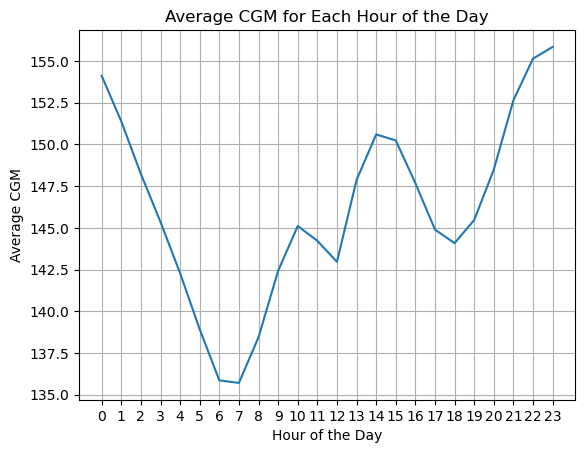

In [13]:
# Extract the hour from the index and group by it
df_glucose['hour'] = df_glucose.index.hour
hourly_avg = df_glucose.groupby('hour')['CGM'].mean()

# Plot the average CGM for each hour of the day
plt.plot(hourly_avg.index, hourly_avg.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Average CGM')
plt.title('Average CGM for Each Hour of the Day')
plt.xticks(range(24))  # Show all 24 hours on the x-axis
plt.grid(True)
plt.show()

The results are very typical. Morning blood glucose is good, while throughout the day, and especially after dinner time, they increase.

# Systematic check of content in each file in the dataset

## CM - Concomitant Medications

CM dataset contains information about pump, closed loop, or MDI insulin use at baseline per patient report. Participant reported use of other medications to lower blood sugar at baseline are found in the CM domain.

In [14]:
cm = get_df_from_zip_deflate_64(zip_path, 'CM.xpt') 

In [20]:
cm.head()

,STUDYID,DOMAIN,USUBJID,CMSEQ,CMGRPID,CMTRT,CMCAT,CMSCAT,CMPRESP,CMSTRTPT,CMSTTPT,CMENRTPT,CMENTPT,DRDELMTD
0,T1DEXI,CM,1,1.0,3.0,BASAL INSULIN,DIABETES TREATMENT,MULTIPLE DAILY INJECTIONS,Y,BEFORE,21982.0,ONGOING,21982.0,
1,T1DEXI,CM,1,2.0,4.0,BOLUS INSULIN,DIABETES TREATMENT,MULTIPLE DAILY INJECTIONS,Y,BEFORE,21982.0,ONGOING,21982.0,
2,T1DEXI,CM,1,3.0,4.0,HUMALOG,DIABETES TREATMENT,"MDI, BOLUS INSULIN",Y,BEFORE,21982.0,ONGOING,21982.0,INSULIN PEN
3,T1DEXI,CM,1,4.0,3.0,LANTUS,DIABETES TREATMENT,"MDI, BASAL INSULIN",Y,BEFORE,21982.0,ONGOING,21982.0,INSULIN PEN
4,T1DEXI,CM,1000,1.0,1.0,HUMALOG,DIABETES TREATMENT,PUMP OR CLOSED LOOP,Y,BEFORE,22138.0,ONGOING,22138.0,PUMP


In [16]:
#cm = create_sas_date_for_column(cm, 'CMSTTPT')
#cm = create_sas_date_for_column(cm, 'CMENTPT')
print_unique_vals(cm, max_vals=5)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['CM'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012'], total unique values: 502
CMSEQ: [1. 2. 3. 4. 5.], total unique values: 5
CMGRPID: [3. 4. 1. 5.], total unique values: 4
CMTRT: ['BASAL INSULIN' 'BOLUS INSULIN' 'HUMALOG' 'LANTUS'
 'PUMP OR CLOSED LOOP INSULIN'], total unique values: 19
CMCAT: ['DIABETES TREATMENT'], total unique values: 1
CMSCAT: ['MULTIPLE DAILY INJECTIONS' 'MDI, BOLUS INSULIN' 'MDI, BASAL INSULIN'
 'PUMP OR CLOSED LOOP' 'LOWER BLOOD SUGAR'], total unique values: 5
CMPRESP: ['Y' ''], total unique values: 2
CMSTRTPT: ['BEFORE'], total unique values: 1
CMSTTPT: [21982. 22138. 22199. 21880. 21866.], total unique values: 344
CMENRTPT: ['ONGOING'], total unique values: 1
CMENTPT: [21982. 22138. 22199. 21880. 21866.], total unique values: 344
DRDELMTD: ['' 'INSULIN PEN' 'PUMP' 'CLOSED LOOP' 'INSULIN PEN (SANOFI SOLOSTAR)'], total unique values: 10


In [17]:
cm['DRDELMTD'].unique()  # We observe that the value is either empty, starts with insulin pen, closed loop, or pump

array(['', 'INSULIN PEN', 'PUMP', 'CLOSED LOOP',
       'INSULIN PEN (SANOFI SOLOSTAR)', 'INSULIN PEN (NOVO FLEXPEN)',
       'INSULIN PEN (NOVO FLEXTOUCH)', 'SYRINGE-VIAL',
       'INSULIN PEN (LILLY KWIKPEN)', 'INSULIN PEN (INPEN)'], dtype=object)

In [21]:
cm['CMSCAT'].unique() 

array(['MULTIPLE DAILY INJECTIONS', 'MDI, BOLUS INSULIN',
       'MDI, BASAL INSULIN', 'PUMP OR CLOSED LOOP', 'LOWER BLOOD SUGAR'],
      dtype=object)

In [22]:
cm['CMTRT'].unique() 

array(['BASAL INSULIN', 'BOLUS INSULIN', 'HUMALOG', 'LANTUS',
       'PUMP OR CLOSED LOOP INSULIN', 'REGULAR (R)', 'NOVORAPID', 'FIASP',
       'TRESIBA', 'METFORMIN', 'TOUJEO', 'NOVOLOG/FIASP', 'LEVEMIR',
       'APIDRA', 'LYUMJEV', 'NOVOLOG', 'BASAGLAR', 'ADMELOG',
       'LYUMJEV (LISPRO-AABC)'], dtype=object)

CMTRT is the reported name of drug, medication or therapy. DRDELMTD is delivery method. 

In [31]:
# Count if all unique subjects have added an insulin type, and how many insulin types per subject
fast_acting_insulins = [
    'HUMALOG',
    'NOVORAPID',
    'FIASP',
    'NOVOLOG/FIASP',
    'APIDRA',
    'LYUMJEV',
    'NOVOLOG',
    'ADMELOG',
    'LYUMJEV (LISPRO-AABC)'
]
long_acting_insulins = [
    'LANTUS',    
    'LEVEMIR',
    'TRESIBA',
    'TOUJEO',
    'BASAGLAR',
]

In [36]:
# TOTAL IDS IN DATASET IS 502
filtered_cm = cm[cm['CMTRT'].isin(fast_acting_insulins)]
matching_ids = filtered_cm['USUBJID'].unique().tolist()

# Check for duplicates to see if any ID has more than one therapy
duplicate_ids = filtered_cm['USUBJID'][filtered_cm['USUBJID'].duplicated()].unique()
print(f'Dataset has short acting insulin for {len(matching_ids)}/502 subjects. Duplicates: {duplicate_ids}')

Dataset has short acting insulin for 498/502 subjects. Duplicates: ['1206' '1363']


In [40]:
filtered_cm.head()

,STUDYID,DOMAIN,USUBJID,CMSEQ,CMGRPID,CMTRT,CMCAT,CMSCAT,CMPRESP,CMSTRTPT,CMSTTPT,CMENRTPT,CMENTPT,DRDELMTD
2,T1DEXI,CM,1,3.0,4.0,HUMALOG,DIABETES TREATMENT,"MDI, BOLUS INSULIN",Y,BEFORE,21982.0,ONGOING,21982.0,INSULIN PEN
4,T1DEXI,CM,1000,1.0,1.0,HUMALOG,DIABETES TREATMENT,PUMP OR CLOSED LOOP,Y,BEFORE,22138.0,ONGOING,22138.0,PUMP
6,T1DEXI,CM,1004,1.0,1.0,HUMALOG,DIABETES TREATMENT,PUMP OR CLOSED LOOP,Y,BEFORE,22199.0,ONGOING,22199.0,PUMP
10,T1DEXI,CM,1012,1.0,1.0,NOVORAPID,DIABETES TREATMENT,PUMP OR CLOSED LOOP,Y,BEFORE,21866.0,ONGOING,21866.0,CLOSED LOOP
12,T1DEXI,CM,1013,1.0,1.0,NOVORAPID,DIABETES TREATMENT,PUMP OR CLOSED LOOP,Y,BEFORE,21863.0,ONGOING,21863.0,PUMP


In [37]:
cm_with_duplicates = cm[cm['USUBJID'].isin(duplicate_ids)]
cm_with_duplicates

,STUDYID,DOMAIN,USUBJID,CMSEQ,CMGRPID,CMTRT,CMCAT,CMSCAT,CMPRESP,CMSTRTPT,CMSTTPT,CMENRTPT,CMENTPT,DRDELMTD
163,T1DEXI,CM,1206,1.0,3.0,BASAL INSULIN,DIABETES TREATMENT,MULTIPLE DAILY INJECTIONS,Y,BEFORE,21996.0,ONGOING,21996.0,
164,T1DEXI,CM,1206,2.0,4.0,BOLUS INSULIN,DIABETES TREATMENT,MULTIPLE DAILY INJECTIONS,Y,BEFORE,21996.0,ONGOING,21996.0,
165,T1DEXI,CM,1206,3.0,3.0,HUMALOG,DIABETES TREATMENT,"MDI, BASAL INSULIN",,BEFORE,21996.0,ONGOING,21996.0,INSULIN PEN
166,T1DEXI,CM,1206,4.0,4.0,HUMALOG,DIABETES TREATMENT,"MDI, BOLUS INSULIN",Y,BEFORE,21996.0,ONGOING,21996.0,INSULIN PEN
167,T1DEXI,CM,1206,5.0,3.0,LEVEMIR,DIABETES TREATMENT,"MDI, BASAL INSULIN",Y,BEFORE,21996.0,ONGOING,21996.0,SYRINGE-VIAL
301,T1DEXI,CM,1363,1.0,3.0,BASAL INSULIN,DIABETES TREATMENT,MULTIPLE DAILY INJECTIONS,Y,BEFORE,22312.0,ONGOING,22312.0,
302,T1DEXI,CM,1363,2.0,4.0,BOLUS INSULIN,DIABETES TREATMENT,MULTIPLE DAILY INJECTIONS,Y,BEFORE,22312.0,ONGOING,22312.0,
303,T1DEXI,CM,1363,3.0,4.0,HUMALOG,DIABETES TREATMENT,"MDI, BOLUS INSULIN",Y,BEFORE,22312.0,ONGOING,22312.0,INSULIN PEN (LILLY KWIKPEN)
304,T1DEXI,CM,1363,4.0,4.0,NOVORAPID,DIABETES TREATMENT,"MDI, BOLUS INSULIN",Y,BEFORE,22312.0,ONGOING,22312.0,INSULIN PEN (NOVO FLEXPEN)
305,T1DEXI,CM,1363,5.0,3.0,TOUJEO,DIABETES TREATMENT,"MDI, BASAL INSULIN",Y,BEFORE,22312.0,ONGOING,22312.0,INSULIN PEN (SANOFI SOLOSTAR)


In [61]:
# Creating a bolus therapy table
bolus_insulin_df = cm[cm['CMTRT'].isin(fast_acting_insulins)]
bolus_insulin_df = bolus_insulin_df[['USUBJID', 'CMTRT', 'DRDELMTD']]
bolus_insulin_df.rename(columns={'USUBJID': 'subject_id', 'CMTRT': 'bolus_insulin', 'DRDELMTD': 'delivery_type'}, inplace=True)
bolus_insulin_df.drop_duplicates(inplace=True)
bolus_insulin_df

,subject_id,bolus_insulin,delivery_type
2,1,HUMALOG,INSULIN PEN
4,1000,HUMALOG,PUMP
6,1004,HUMALOG,PUMP
10,1012,NOVORAPID,CLOSED LOOP
12,1013,NOVORAPID,PUMP
...,...,...,...
1193,979,NOVORAPID,INSULIN PEN (INPEN)
1197,981,NOVORAPID,INSULIN PEN
1198,985,HUMALOG,PUMP
1202,987,NOVORAPID,INSULIN PEN (INPEN)


In [62]:
duplicate_ids = insulin_therapy_df['subject_id'][insulin_therapy_df['subject_id'].duplicated()].unique()
duplicate_ids

array(['1363'], dtype=object)

In [63]:
# Creating a basal insulin therapy table
basal_insulin_df = cm[cm['CMTRT'].isin(long_acting_insulins)]
basal_insulin_df = basal_insulin_df[['USUBJID', 'CMTRT', 'DRDELMTD']]
basal_insulin_df.rename(columns={'USUBJID': 'subject_id', 'CMTRT': 'basal_insulin', 'DRDELMTD': 'delivery_type'}, inplace=True)
basal_insulin_df.drop_duplicates(inplace=True)
basal_insulin_df

,subject_id,basal_insulin,delivery_type
3,1,LANTUS,INSULIN PEN
18,1015,LANTUS,INSULIN PEN (SANOFI SOLOSTAR)
31,1024,TRESIBA,INSULIN PEN
35,103,TRESIBA,INSULIN PEN (NOVO FLEXTOUCH)
72,110,TRESIBA,INSULIN PEN
...,...,...,...
1146,920,TRESIBA,INSULIN PEN
1152,932,TRESIBA,INSULIN PEN
1192,979,LANTUS,INSULIN PEN (SANOFI SOLOSTAR)
1196,981,LEVEMIR,INSULIN PEN


## DM - Demographics

DM domain contains basic demographic information, such as age, sex, race, ethnicity, etc. Because the baselineCRF allowed for selection of multiple races, a supplemental dataset (SUPPDM) was used to report thisinformation.

In [64]:
dm = get_df_from_zip_deflate_64(zip_path, 'DM.xpt') 

In [66]:
dm.head(3)

,STUDYID,DOMAIN,USUBJID,RFICDTC,SITEID,BRTHDTC,AGE,AGEU,SEX,RACE,ETHNIC,ARMCD,ARM,ACTARMCD,ACTARM,COUNTRY
0,T1DEXI,DM,1,21982.0,1.0,14217.0,21.0,Years,F,WHITE,Not Hispanic or Latino,RESISTANCE,Resistance,RESISTANCE,Resistance,USA
1,T1DEXI,DM,1000,22138.0,1.0,12778.0,25.0,Years,F,WHITE,Not Hispanic or Latino,RESISTANCE,Resistance,RESISTANCE,Resistance,USA
2,T1DEXI,DM,1004,22199.0,1.0,3984.0,49.0,Years,F,WHITE,Not Hispanic or Latino,AEROBIC,Aerobic,AEROBIC,Aerobic,USA


In [69]:
print_unique_vals(dm, max_vals=10)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['DM'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012' '1013' '1014' '1015' '1016' '1020'], total unique values: 502
RFICDTC: [21982. 22138. 22199. 21880. 21866. 21863. 21843. 22160. 22026. 21777.], total unique values: 349
SITEID: [1.], total unique values: 1
BRTHDTC: [14217. 12778.  3984.  9734. 13931. 10926. 10866. -2061. 14800. 10509.], total unique values: 491
AGE: [21. 25. 49. 33. 29. 30. 66. 19. 61. 22.], total unique values: 53
AGEU: ['Years'], total unique values: 1
SEX: ['F' 'M'], total unique values: 2
RACE: ['WHITE' 'NOT REPORTED' 'ASIAN' 'BLACK/AFRICAN AMERICAN' 'MULTIPLE'
 'UNKNOWN' 'AMERICAN INDIAN/ALASKAN NATIVE'], total unique values: 7
ETHNIC: ['Not Hispanic or Latino' 'Hispanic or Latino' 'Do not wish to answer'
 "Don't know"], total unique values: 4
ARMCD: ['RESISTANCE' 'AEROBIC' 'INTERVAL'], total unique values: 3
ARM: ['Resistance' 'Aerobic' 'Interval'], total unique values: 3
ACTARMCD: ['RESIST

The ARMCD indicates which exercise type this subject was assigned (each subject was randomly assigned to only one type).
BRTHDTC is birth date. 

In [75]:
demographics_df = dm[['USUBJID', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'ARM']]
demographics_df.head()

,USUBJID,AGE,SEX,RACE,ETHNIC,ARM
0,1,21.0,F,WHITE,Not Hispanic or Latino,Resistance
1,1000,25.0,F,WHITE,Not Hispanic or Latino,Resistance
2,1004,49.0,F,WHITE,Not Hispanic or Latino,Aerobic
3,1010,33.0,F,WHITE,Not Hispanic or Latino,Interval
4,1012,21.0,M,WHITE,Not Hispanic or Latino,Resistance


## DX - Device Exposure

DX domain contains records for participant indicated insulin modality selected at screening, and additional
information about the pump or closed loop system in use at baseline if one of these modalities were indicated by
participant.

In [80]:
dx = get_df_from_zip_deflate_64(zip_path, 'DX.xpt') 

In [81]:
dx.head(3)

,STUDYID,DOMAIN,USUBJID,SPDEVID,DXSEQ,DXTRT,DXCAT,DXSCAT,DXPRESP,VISIT,DXDTC,DXSTRTPT,DXENRTPT,DXEVINTX
0,T1DEXI,DX,1,IP-25,1.0,MULTIPLE DAILY INJECTIONS,INSULIN MODALITY,,Y,BASELINE,21982.0,BEFORE,ONGOING,USUALLY
1,T1DEXI,DX,1000,IP-1,1.0,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,INSULIN PUMP HISTORY,CURRENT,Y,BASELINE,22138.0,BEFORE,ONGOING,
2,T1DEXI,DX,1000,IP-24,2.0,INSULIN PUMP,INSULIN MODALITY,,Y,BASELINE,22138.0,BEFORE,ONGOING,USUALLY


In [82]:
print_unique_vals(dx, max_vals=5)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['DX'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012'], total unique values: 502
SPDEVID: ['IP-25' 'IP-1' 'IP-24' 'IP-5' 'IP-26'], total unique values: 21
DXSEQ: [1. 2.], total unique values: 2
DXTRT: ['MULTIPLE DAILY INJECTIONS' 'INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM'
 'INSULIN PUMP' 'MEDTRONIC 670G IN MANUAL MODE' 'CLOSED LOOP INSULIN PUMP'], total unique values: 21
DXCAT: ['INSULIN MODALITY' 'INSULIN PUMP HISTORY'], total unique values: 2
DXSCAT: ['' 'CURRENT'], total unique values: 2
DXPRESP: ['Y' ''], total unique values: 2
VISIT: ['BASELINE'], total unique values: 1
DXDTC: [21982. 22138. 22199. 21880. 21866.], total unique values: 344
DXSTRTPT: ['BEFORE'], total unique values: 1
DXENRTPT: ['ONGOING'], total unique values: 1
DXEVINTX: ['USUALLY' ''], total unique values: 2


## ML - Meal Data

Measurements of the energy and nutrient intake of people why living in their natural environment. 

In [83]:
ml = get_df_from_zip_deflate_64(zip_path, 'ML.xpt') 

In [84]:
ml.head(3)

,STUDYID,DOMAIN,USUBJID,MLSEQ,MLGRPID,MLTRT,MLCAT,MLDOSE,MLDOSU,MLDOSFRQ,MLDTC,MLDECDCD,MLDNAMVR
0,T1DEXI,ML,1,1.0,77777.0,MEAL,USUAL DAILY CONSUMPTION,3.0,,QD,1.899245e+09,NaN,
1,T1DEXI,ML,1,2.0,88888.0,SNACK,USUAL DAILY CONSUMPTION,2.0,,QD,1.899245e+09,NaN,
2,T1DEXI,ML,1,3.0,99999.0,SNACK,RESCUE CARBS,28.0,g,,1.904858e+09,NaN,


In [102]:
print_unique_vals(ml, max_vals=8)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['ML'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012' '1013' '1014' '1015'], total unique values: 502
MLSEQ: [1. 2. 3. 4. 5. 6. 7. 8.], total unique values: 429
MLGRPID: [77777. 88888. 99999. 31004. 31107. 31178. 31241. 32229.], total unique values: 17005
MLTRT: ['MEAL' 'SNACK' 'Almonds, unsalted' 'Bacon bits'
 'Bacon, NS as to type of meat, cooked' 'Beef jerky'
 'Broccoli, cooked, NS as to form, NS as to fat added in cooking'
 'Caramel with nuts, chocolate covered'], total unique values: 3246
MLCAT: ['USUAL DAILY CONSUMPTION' 'RESCUE CARBS' 'Breakfast' 'Dinner' 'Lunch'
 'Evening Snack' 'Afternoon Snack' 'Morning Snack'], total unique values: 8
MLDOSE: [ 3.  2. 28. 19. 53. 26. 27. 30.], total unique values: 3938
MLDOSU: ['' 'g'], total unique values: 2
MLDOSFRQ: ['QD' ''], total unique values: 2
MLDTC: [1.89924480e+09 1.90485794e+09 1.90488066e+09 1.90488933e+09
 1.90493496e+09 1.90494966e+09 1.90503121e+09 1.905091

In [93]:
df_meals = create_sas_date_for_column(ml.copy(), 'MLDTC')
df_meals['MLDOSE'] = pd.to_numeric(df_meals['MLDOSE'], errors='coerce')
df_meals.rename(
    columns={'MLDOSE': 'meal_grams', 'MLTRT': 'meal_label', 'MLCAT': 'meal_category', 'MLDTC': 'date',
             'USUBJID': 'id'}, inplace=True)
df_meals = df_meals[['meal_grams', 'meal_label', 'meal_category', 'id', 'date']]

In [96]:
df_meals.tail(5)

,meal_grams,meal_label,meal_category,id,date
62470,38.00,"Watermelon, raw",Evening Snack,988,2021-04-12 21:54:18
62471,103.00,"Yogurt, Greek, nonfat milk, flavors other than...",Evening Snack,988,2021-04-12 21:54:18
62472,67.98,"Yogurt, Greek, nonfat milk, flavors other than...",Breakfast,988,2021-04-13 08:51:21
62473,132.00,"Yogurt, Greek, nonfat milk, fruit",Lunch,988,2021-04-13 12:58:33
62474,255.00,"Yogurt, Greek, whole milk, fruit",Afternoon Snack,988,2021-04-12 16:16:27


In [103]:
# Checking for duplicate dates, to see if there is anything concerning
duplicate_dates = df_meals['date'][df_meals['date'].duplicated()].unique()
filtered_meals = df_meals[df_meals['date'].isin(duplicate_dates)]
filtered_meals.sort_values(by=['date'], inplace=True)
filtered_meals.head(10)

/opt/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,meal_grams,meal_label,meal_category,id,date
46945,384.00,"Nutritional drink or shake, high protein, read...",Breakfast,576,2019-02-20 08:15:00
46917,372.00,Energy Drink,Breakfast,576,2019-02-20 08:15:00
46978,160.00,"Potato, hash brown, ready-to-heat, with cheese",Lunch,576,2019-02-20 12:30:00
46964,56.70,Polish sausage,Lunch,576,2019-02-20 12:30:00
46967,22.05,Poppy seed dressing,Dinner,576,2019-02-20 18:56:15
46934,62.50,"Kale, raw",Dinner,576,2019-02-20 18:56:15
46963,73.50,"Pizza, cheese, from frozen, thick crust",Dinner,576,2019-02-20 18:56:15
46953,44.00,"Nutritional powder mix, high protein, NFS",Breakfast,576,2019-02-21 08:20:00
46938,244.00,"Milk, NFS",Breakfast,576,2019-02-21 08:20:00
46887,28.00,"Bread, NS as to major flour",Dinner,576,2019-02-21 18:32:19


We observe that for each meal, it is separated into separate rows for each meal component. 

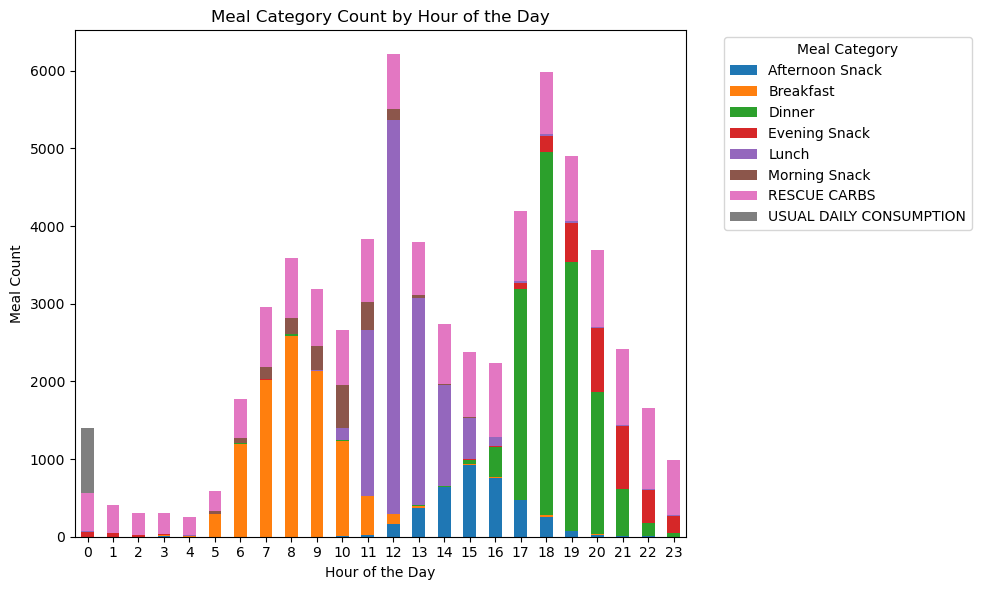

In [104]:
df_meals['hour'] = df_meals['date'].dt.hour
meal_counts = df_meals.groupby(['hour', 'meal_category']).size().unstack(fill_value=0)
meal_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Meal Count')
plt.title('Meal Category Count by Hour of the Day')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Meal Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [108]:
# Meals per subject (used to compare to the carbohydrate dataframe later)
df_meals['date'] = pd.to_datetime(df_meals['date'])
unique_dates_count = df_meals.groupby('id')['date'].nunique()
unique_dates_count.head()

Variable
id
1       133
1000     56
1004      7
1010     97
1012     77
dtype: int64

In [113]:
len(unique_dates_count) # Verify that it equal totla amount of subjects (502)

502

In [110]:
# Total meals, mean, and std
print(f'Total meals: {unique_dates_count.sum()}, mean and std per id: {unique_dates_count.mean()} ({unique_dates_count.std()})')

Total meals: 33790, mean and std per id: 67.31075697211155 (45.5247409629666)


In [ ]:
# TODO: WHEN COMES TO INSULIN, CHECK THAT THE DOSE MATCHES THE MEAL DOSES!!!

## PR - Procedures

PR domain contains participant reported exercise data and additional exercise related data from study application, such as exercise duration, time since last meal, intensity, etc.

In [241]:
pr = get_df_from_zip_deflate_64(zip_path, 'PR.xpt') 

In [242]:
pr.head()

,STUDYID,DOMAIN,USUBJID,PRSEQ,PRTRT,PRCAT,PRSCAT,PRSTDTC,PRTRTC,PLNEXDUR,EXCINTSY,HRSLSTML,EXCOMP,SNKBEFEX,INUSDTDY,BETAGTDY,RESQCARB
0,T1DEXI,PR,1,1.0,Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),1.905243e+09,Biking (Indoor or Outdoor),180.0,1,2 hours,0,1,0,0,0
1,T1DEXI,PR,1,2.0,Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),1.905417e+09,Biking (Indoor or Outdoor),88.0,1,>4 hours,0,1,0,0,0
2,T1DEXI,PR,1,3.0,Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),1.906451e+09,Biking (Indoor or Outdoor),228.0,1,<1 hour,0,1,0,0,0
3,T1DEXI,PR,1,4.0,Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),1.906636e+09,Biking (Indoor or Outdoor),87.0,1,<1 hour,0,1,0,0,0
4,T1DEXI,PR,1,5.0,Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),1.906799e+09,Biking (Indoor or Outdoor),135.0,1,<1 hour,0,1,0,0,1


In [243]:
print_unique_vals(pr, max_vals=5)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['PR'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012'], total unique values: 502
PRSEQ: [1. 2. 3. 4. 5.], total unique values: 121
PRTRT: ['Biking (Indoor or Outdoor)' 'Hiking'
 'Jogging/Running (Indoor or Outdoor)' 'Snowshoeing' 'Study Video'], total unique values: 49
PRCAT: ['Biking (Indoor or Outdoor)' 'Hiking'
 'Jogging/Running (Indoor or Outdoor)' 'Snowshoeing' 'Study Video'], total unique values: 49
PRSCAT: ['Biking (Indoor or Outdoor)' 'Hiking'
 'Jogging/Running (Indoor or Outdoor)' 'Snow Shoeing' 'Study Video'], total unique values: 246
PRSTDTC: [1.90524261e+09 1.90541704e+09 1.90645117e+09 1.90663640e+09
 1.90679876e+09], total unique values: 15079
PRTRTC: ['Biking (Indoor or Outdoor)' 'Hiking'
 'Jogging/Running (Indoor or Outdoor)' 'Snow Shoeing' 'Study Video'], total unique values: 293
PLNEXDUR: [180.  88. 228.  87. 135.], total unique values: 209
EXCINTSY: ['1' '0' '2'], total unique values: 3
HRSLSTML: 

In [244]:
df_exercise = create_sas_date_for_column(pr.copy(), 'PRSTDTC')
df_exercise.rename(
    columns={'PRCAT': 'category', 'PRTRTC': 'type', 'PLNEXDUR': 'duration (minutes)', 'EXCINTSY': 'intensity', 'PRSTDTC': 'date',
             'USUBJID': 'id'}, inplace=True)
df_exercise = df_exercise[['category', 'type', 'duration (minutes)', 'intensity', 'id', 'date']]
df_exercise.sort_values(by=['id'], inplace=True)
df_exercise

,category,type,duration (minutes),intensity,id,date
0,Biking (Indoor or Outdoor),Biking (Indoor or Outdoor),180.0,1,1,2020-05-16 10:03:30
19,Study Video,Study Video,30.0,0,1,2020-05-21 21:29:02
20,Study Video,Study Video,32.0,1,1,2020-05-28 09:15:29
22,Swimming,Swimming,41.0,1,1,2020-05-13 12:04:27
23,Swimming,Swimming,42.0,1,1,2020-05-15 11:03:44
...,...,...,...,...,...,...
15075,Cleaning/Housework,Cleaning/Housework,44.0,0,988,2021-04-06 13:44:11
15074,"Cardio (Elliptical, Rower, StairMaster)","Cardio (Elliptical, Rower, StairMaster)",32.0,1,988,2021-04-02 09:24:04
15102,"Walking, Dog Walking","Walking, Dog Walking",25.0,1,988,2021-04-07 11:52:43
15087,Outdoor Chores,Outdoor Chores,60.0,2,988,2021-04-15 18:05:04


In [246]:
# When category and type are different, what is the difference? 
df_exercise[df_exercise['category'] != df_exercise['type']].sample(n=30)

,category,type,duration (minutes),intensity,id,date
2867,Exercise Video/Class Misc,Les Mills BodyPump,30.0,2,1297,2020-10-18 09:30:28
1955,Rowing (Indoor or Outdoor),Kayaking+,90.0,1,1205,2019-12-18 13:30:00
13526,Aerobic Exercise (Misc),jump rope,26.0,1,812,2021-02-23 20:11:07
2845,Abdominal/Core Exercise,Les Mills cx worx,30.0,1,1297,2020-10-11 10:00:44
12058,Skiing,skiing,240.0,1,66,2020-08-07 09:00:02
10137,Volleyball,volleyball/ volleyball coaching,120.0,1,471,2020-04-06 18:00:27
6774,"Walking, Dog Walking",walking- (no dog),56.0,0,1666,2021-04-26 15:00:44
4574,Exercise Video/Class Misc,tv video,20.0,2,1441,2020-05-24 14:31:42
8841,Aerobic Exercise (Misc),Jumprope,16.0,1,37,2021-02-02 12:23:00
11118,Biking (Indoor or Outdoor),cycling,30.0,1,577,2019-12-05 07:48:59


Type generally seems slightly more specific / descriptive, and they are most of the time very overlapping, so we should choose one of the columns category / type. 

## LB - Laboratory Test Results

The LB domain contains records for most recent HbA1c as reported by participant at baseline, and Dexcom G6 continuous glucose monitoring (CGM) data during study period. Dexcom G6 data is typically recorded once every five minutes.

In [235]:
lb = get_df_from_zip_deflate_64(zip_path, 'LB.xpt') 

In [236]:
lb.head()

,STUDYID,DOMAIN,USUBJID,LBSEQ,LBTESTCD,LBTEST,LBCAT,LBORRES,LBORRESU,LBSTRESC,LBSTRESN,LBSTRESU,LBDTC,LBSOURCE,LBCRNORD,LBSETTNG,LBTMINT
0,T1DEXI,LB,1,1.0,GLUC,Glucose,CGM,115.0,mg/dL,115,115.0,mg/dL,1.904774e+09,,,,
1,T1DEXI,LB,1,2.0,GLUC,Glucose,CGM,109.0,mg/dL,109,109.0,mg/dL,1.904775e+09,,,,
2,T1DEXI,LB,1,3.0,GLUC,Glucose,CGM,105.0,mg/dL,105,105.0,mg/dL,1.904775e+09,,,,
3,T1DEXI,LB,1,4.0,GLUC,Glucose,CGM,106.0,mg/dL,106,106.0,mg/dL,1.904775e+09,,,,
4,T1DEXI,LB,1,5.0,GLUC,Glucose,CGM,110.0,mg/dL,110,110.0,mg/dL,1.904776e+09,,,,


In [237]:
print_unique_vals(lb, max_vals=5)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['LB'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012'], total unique values: 502
LBSEQ: [1. 2. 3. 4. 5.], total unique values: 15765
LBTESTCD: ['GLUC' 'HBA1C'], total unique values: 2
LBTEST: ['Glucose' 'Hemoglobin A1c'], total unique values: 2
LBCAT: ['CGM' 'DIABETES HISTORY'], total unique values: 2
LBORRES: [115. 109. 105. 106. 110.], total unique values: 405
LBORRESU: ['mg/dL' '%'], total unique values: 2
LBSTRESC: ['115' '109' '105' '106' '110'], total unique values: 405
LBSTRESN: [115. 109. 105. 106. 110.], total unique values: 405
LBSTRESU: ['mg/dL' '%'], total unique values: 2
LBDTC: [1.90477448e+09 1.90477478e+09 1.90477508e+09 1.90477538e+09
 1.90477568e+09], total unique values: 3666802
LBSOURCE: ['' 'SUBJECT RECALL'], total unique values: 2
LBCRNORD: ['' 'MOST RECENT'], total unique values: 2
LBSETTNG: ['' "DOCTOR'S OFFICE OR LAB"], total unique values: 2
LBTMINT: ['' '< 3 MONTHS' '3 MONTHS - < 6 MONTHS'

In [239]:
lb[lb['LBTESTCD'] == 'GLUC']['LBSTRESU'].unique()

array(['mg/dL'], dtype=object)

## NV - Nervous System Finding

NV domain contains sleep data from the Verily device, including a variety of summary sleep measures such as total sleep time, wake after sleep, efficiency, and REM measures.

In [146]:
nv = get_df_from_zip_deflate_64(zip_path, 'NV.xpt') 
nv.head()

,STUDYID,DOMAIN,USUBJID,NVSEQ,NVTESTCD,NVTEST,NVORRES,NVORRESU,NVSTRESC,NVSTRESN,NVSTRESU,NVMETHOD,NVDTC,NVENDTC
0,T1DEXI,NV,1,1.0,DNREMDUR,Deep NREM Duration,2550000.0,msec,2550000,2550000.0,msec,POLYSOMNOGRAPHY,1.904859e+09,1.904889e+09
1,T1DEXI,NV,1,2.0,DNREMDUR,Deep NREM Duration,4350000.0,msec,4350000,4350000.0,msec,POLYSOMNOGRAPHY,1.905211e+09,1.905236e+09
2,T1DEXI,NV,1,3.0,DNREMDUR,Deep NREM Duration,1980000.0,msec,1980000,1980000.0,msec,POLYSOMNOGRAPHY,1.905296e+09,1.905328e+09
3,T1DEXI,NV,1,4.0,DNREMDUR,Deep NREM Duration,2910000.0,msec,2910000,2910000.0,msec,POLYSOMNOGRAPHY,1.905377e+09,1.905408e+09
4,T1DEXI,NV,1,5.0,DNREMDUR,Deep NREM Duration,5070000.0,msec,5070000,5070000.0,msec,POLYSOMNOGRAPHY,1.905556e+09,1.905581e+09


In [147]:
print_unique_vals(nv, max_vals=5)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['NV'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012'], total unique values: 497
NVSEQ: [1. 2. 3. 4. 5.], total unique values: 306
NVTESTCD: ['DNREMDUR' 'LNREMDUR' 'NREMDUR' 'NUMAWAKE' 'REMDUR'], total unique values: 9
NVTEST: ['Deep NREM Duration' 'Light NREM Duration' 'NREM Duration'
 'Number of Awakenings' 'REM Duration'], total unique values: 9
NVORRES: [2550000. 4350000. 1980000. 2910000. 5070000.], total unique values: 1230
NVORRESU: ['msec' ''], total unique values: 2
NVSTRESC: ['2550000' '4350000' '1980000' '2910000' '5070000'], total unique values: 1230
NVSTRESN: [2550000. 4350000. 1980000. 2910000. 5070000.], total unique values: 1230
NVSTRESU: ['msec' ''], total unique values: 2
NVMETHOD: ['POLYSOMNOGRAPHY'], total unique values: 1
NVDTC: [1.90485904e+09 1.90521136e+09 1.90529612e+09 1.90537702e+09
 1.90555612e+09], total unique values: 10013
NVENDTC: [1.90488904e+09 1.90523612e+09 1.90532792e+09 1.905408

We currently have not included sleep data in the dataset, but could be something we would want to include in the future.

## QS - Questionnaires


In [150]:
qs = get_df_from_zip_deflate_64(zip_path, 'QS.xpt') 
qs.head(3)

,STUDYID,DOMAIN,USUBJID,QSSEQ,QSTESTCD,QSTEST,QSCAT,QSORRES,QSORRESU,QSSTRESC,QSSTRESN,QSSTRESU,QSDTC
0,T1DEXI,QS,1,1.0,CHU0101,CHU01-Category Best Describes You,CLARK HYPOGLYCEMIA UNAWARENESS SURVEY SELF ADM...,I always have symptoms when my BG is low,,I always have symptoms when my BG is low,NaN,,21982.0
1,T1DEXI,QS,1,2.0,CHU0102,CHU01-Lost Some Symptoms Blood Sugar Low,CLARK HYPOGLYCEMIA UNAWARENESS SURVEY SELF ADM...,No,,No,NaN,,21982.0
2,T1DEXI,QS,1,3.0,CHU0103,CHU01-Moderate Hypo Espisodes-P6M,CLARK HYPOGLYCEMIA UNAWARENESS SURVEY SELF ADM...,Once or twice,,Once or twice,NaN,,21982.0


In [149]:
print_unique_vals(qs, max_vals=5)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['QS'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012'], total unique values: 502
QSSEQ: [1. 2. 3. 4. 5.], total unique values: 34
QSTESTCD: ['CHU0101' 'CHU0102' 'CHU0103' 'CHU0104' 'CHU0105'], total unique values: 34
QSTEST: ['CHU01-Category Best Describes You'
 'CHU01-Lost Some Symptoms Blood Sugar Low'
 'CHU01-Moderate Hypo Espisodes-P6M' 'CHU01-Severe Hypo Episodes-P1Y'
 'CHU01-<70 mg/dL w/ Symptoms-P1M'], total unique values: 34
QSCAT: ['CLARK HYPOGLYCEMIA UNAWARENESS SURVEY SELF ADMINISTERED'
 'IPAQ SHORT - SELF ADMINISTERED VERSION' 'PITTSBURG SLEEP QUALITY INDEX'], total unique values: 3
QSORRES: ['I always have symptoms when my BG is low' 'No' 'Once or twice' 'Never'
 'Almost daily'], total unique values: 360
QSORRESU: ['' 'mg/dL' 'days/wk' 'min/day' 'HOURS'], total unique values: 5
QSSTRESC: ['I always have symptoms when my BG is low' 'No' 'Once or twice' 'Never'
 'Almost daily'], total unique values: 361
Q

## RP - Reproductive System Findings

Meanstrual cycle data.

In [151]:
rp = get_df_from_zip_deflate_64(zip_path, 'RP.xpt') 
rp.head(3)

,STUDYID,DOMAIN,USUBJID,RPSEQ,RPTESTCD,RPTEST,RPORRES,RPSTRESC,VISIT,RPDTC
0,T1DEXI,RP,1,1.0,HMPIND,Has Menstrual Periods Indicator,Yes,Yes,Baseline,21982.0
1,T1DEXI,RP,1000,1.0,HMPIND,Has Menstrual Periods Indicator,Yes,Yes,Baseline,22138.0
2,T1DEXI,RP,1000,2.0,LMPSTDTC,Last Menstrual Period Start Date,20200721,20200721,Baseline,22138.0


In [152]:
print_unique_vals(rp, max_vals=5)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['RP'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1013'], total unique values: 367
RPSEQ: [1. 2. 3.], total unique values: 3
RPTESTCD: ['HMPIND' 'LMPSTDTC'], total unique values: 2
RPTEST: ['Has Menstrual Periods Indicator' 'Last Menstrual Period Start Date'], total unique values: 2
RPORRES: ['Yes' '20200721' '20201021' '20200922' '20201215'], total unique values: 346
RPSTRESC: ['Yes' '20200721' '20201021' '20200922' '20201215'], total unique values: 346
VISIT: ['Baseline' 'Follow-up'], total unique values: 2
RPDTC: [21982. 22138. 22213. 22199. 22281.], total unique values: 395


## SC - Subject Characteristics

Education, wealth...

In [153]:
sc = get_df_from_zip_deflate_64(zip_path, 'SC.xpt') 
sc.head(3)

,STUDYID,DOMAIN,USUBJID,SCSEQ,SCTESTCD,SCTEST,SCORRES,SCSTRESC,SCDTC
0,T1DEXI,SC,1,1.0,EDULEVEL,EDUCATION LEVEL,Some college but no degree,Some college but no degree,21982.0
1,T1DEXI,SC,1,2.0,HLTHINS,HEALTH INSURANCE TYPE,"Private Health Insurance (e.g., commercial, fe...","Private Health Insurance (e.g., commercial, fe...",21982.0
2,T1DEXI,SC,1,3.0,INCMLVL,INCOME LEVEL,"$200,000 or more","$200,000 or more",21982.0


In [154]:
print_unique_vals(sc, max_vals=5)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['SC'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012'], total unique values: 502
SCSEQ: [1. 2. 3. 4. 5.], total unique values: 5
SCTESTCD: ['EDULEVEL' 'HLTHINS' 'INCMLVL'], total unique values: 3
SCTEST: ['EDUCATION LEVEL' 'HEALTH INSURANCE TYPE' 'INCOME LEVEL'], total unique values: 3
SCORRES: ['Some college but no degree'
 'Private Health Insurance (e.g., commercial, fee-for-service, HMO, PPO, POS)'
 '$200,000 or more' 'Bachelor\x92s Degree (BS, BA, AB)'
 '$35,000 to less than $50,000'], total unique values: 32
SCSTRESC: ['Some college but no degree'
 'Private Health Insurance (e.g., commercial, fee-for-service, HMO, PPO, POS)'
 '$200,000 or more' 'Bachelor\x92s Degree (BS, BA, AB)'
 '$35,000 to less than $50,000'], total unique values: 32
SCDTC: [21982. 22138. 22199. 21880. 21866.], total unique values: 344


## VS - Vital Signs

VS domain contains participant reported height and weight data from baseline and final visit, polar heart rate data, and Verily summary mean heart rate data.

In [155]:
# NOTE! This file is enourmous. Loading will take significant time
# TODO!!! 
vs = get_df_from_zip_deflate_64(zip_path, 'VS.xpt') 
vs.head(3)

KeyboardInterrupt: 

In [ ]:
print_unique_vals(vs, max_vals=5)

## FA - Findings About 
FA domain contains records for age at diabetes onset, Verily step count data, and daily questionnaire datarelating to daily sickness, insulin, stress, and sleep. 

Verily is some activity tracker or something.

In [ ]:
# TODO!!
fa = get_df_from_zip_deflate_64(zip_path, 'FA.xpt') 
fa.head(3)

In [ ]:
print_unique_vals(fa, max_vals=5)

## FACM - Findings About Concominant Medications

Insulin delivery data.

In [7]:
facm = get_df_from_zip_deflate_64(zip_path, 'FACM.xpt') 
facm.head(3)

,STUDYID,DOMAIN,USUBJID,FASEQ,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FASTRESC,FASTRESN,FASTRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL
0,T1DEXI,FA,1,544.0,INSBASAL,BASAL INSULIN,INSULIN,BASAL,28.0000000000,U,28.0000000000,28.0,U,1.904858e+09,,Injections,,NaN,NaN
1,T1DEXI,FA,1,545.0,INSBASAL,BASAL INSULIN,INSULIN,BASAL,1.0000000000,U,1.0000000000,1.0,U,1.904887e+09,,Injections,,NaN,NaN
2,T1DEXI,FA,1,546.0,INSBASAL,BASAL INSULIN,INSULIN,BASAL,1.0000000000,U,1.0000000000,1.0,U,1.904978e+09,,Injections,,NaN,NaN


In [8]:
print_unique_vals(facm, max_vals=5)

STUDYID: ['T1DEXI'], total unique values: 1
DOMAIN: ['FA'], total unique values: 1
USUBJID: ['1' '1000' '1004' '1010' '1012'], total unique values: 493
FASEQ: [544. 545. 546. 547. 548.], total unique values: 124640
FATESTCD: ['INSBASAL' 'INSBOLUS' 'BASFLRT'], total unique values: 3
FATEST: ['BASAL INSULIN' 'BOLUS INSULIN' 'BASAL FLOW RATE'], total unique values: 3
FAOBJ: ['INSULIN'], total unique values: 1
FACAT: ['BASAL' 'BOLUS'], total unique values: 2
FAORRES: ['  28.0000000000' '   1.0000000000' '  20.0000000000' '  18.0000000000'
 '  27.0000000000'], total unique values: 14131
FAORRESU: ['U' 'U/hr'], total unique values: 2
FASTRESC: ['  28.0000000000' '   1.0000000000' '  20.0000000000' '  18.0000000000'
 '  27.0000000000'], total unique values: 14131
FASTRESN: [28.  1. 20. 18. 27.], total unique values: 9143
FASTRESU: ['U' ''], total unique values: 2
FADTC: [1.90485794e+09 1.90488656e+09 1.90497815e+09 1.90505822e+09
 1.90512014e+09], total unique values: 1141203
FADUR: ['' 'P0Y0

In [9]:
df_insulin = create_sas_date_for_column(facm.copy(), 'FADTC')
df_insulin.rename(columns={'FASTRESN': 'dose', 'FATEST': 'type', 'FAORRESU': 'unit', 'FADTC': 'date', 'USUBJID': 'id', 'INSNMBOL': 'total bolus', 'INSEXBOL': 'extended bolus', 'FADUR': 'duration'},
                  inplace=True)
df_insulin = df_insulin[['type', 'INSSTYPE', 'dose', 'unit', 'date', 'id', 'INSDVSRC', 'total bolus', 'extended bolus', 'duration']]

In [10]:
print_unique_vals(df_insulin, max_vals=14)

type: ['BASAL INSULIN' 'BOLUS INSULIN' 'BASAL FLOW RATE'], total unique values: 3
INSSTYPE: ['' 'scheduled' 'temp' 'suspend' 'normal' 'dual/square' 'square'
 'automated' 'combination' 'standard/correction' 'standard'
 'automatic bolus/correction' 'dual (normal part)' 'dual (square part)'], total unique values: 14
dose: [28.  1. 20. 18. 27. 29.  8.  4.  2.  3.  7.  5.  6. 10.], total unique values: 9143
unit: ['U' 'U/hr'], total unique values: 2
date: ['2020-05-11T23:12:21.000000000' '2020-05-12T07:09:22.000000000'
 '2020-05-13T08:35:47.000000000' '2020-05-14T06:50:24.000000000'
 '2020-05-15T00:02:21.000000000' '2020-05-15T00:02:31.000000000'
 '2020-05-15T09:07:57.000000000' '2020-05-15T23:33:58.000000000'
 '2020-05-17T00:41:02.000000000' '2020-05-17T23:16:24.000000000'
 '2020-05-19T08:07:03.000000000' '2020-05-20T01:01:58.000000000'
 '2020-05-21T01:18:07.000000000' '2020-05-23T01:42:37.000000000'], total unique values: 1141203
id: ['1' '1000' '1004' '1010' '1012' '1013' '1014' '1015' '

In [11]:
num_extended = df_insulin['extended bolus'].dropna().shape
num_normal_boluses = df_insulin['total bolus'].dropna().shape
num_doses = df_insulin['dose'].dropna().shape
print(f'extended boluses: {num_extended} vs normal {num_normal_boluses} vs doses {num_doses}')

extended boluses: (2983,) vs normal (82909,) vs doses (2189275,)


In [12]:
sum_bolus = df_insulin['total bolus'].sum()
extended_sum = df_insulin['extended bolus'].sum()
print(f'Total delivery of total bolus: {sum_bolus}, extended: {extended_sum}')

Total delivery of total bolus: 204936.2618500001, extended: 6373.899079999999


In [13]:
df_insulin

,type,INSSTYPE,dose,unit,date,id,INSDVSRC,total bolus,extended bolus,duration
0,BASAL INSULIN,,28.00,U,2020-05-11 23:12:21,1,Injections,NaN,NaN,
1,BASAL INSULIN,,1.00,U,2020-05-12 07:09:22,1,Injections,NaN,NaN,
2,BASAL INSULIN,,1.00,U,2020-05-13 08:35:47,1,Injections,NaN,NaN,
3,BASAL INSULIN,,1.00,U,2020-05-14 06:50:24,1,Injections,NaN,NaN,
4,BASAL INSULIN,,20.00,U,2020-05-15 00:02:21,1,Injections,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...
2217153,BOLUS INSULIN,normal,1.08,U,2021-04-16 16:02:14,988,Pump,1.08,NaN,
2217154,BOLUS INSULIN,normal,0.33,U,2021-04-16 16:03:41,988,Pump,0.33,NaN,
2217155,BOLUS INSULIN,normal,1.42,U,2021-04-16 19:33:20,988,Pump,1.42,NaN,
2217156,BOLUS INSULIN,normal,0.36,U,2021-04-16 20:59:32,988,Pump,0.36,NaN,


QUESTIONS BOLUS DOSES:
- How are extended boluses registered? Is the "total amount of normal bolus" including extended, or registered separately?
- What is the difference between dose, total bolus, and extended bolus?
- What is the difference between 'normal' 'dual/square' 'square'
 'automated' 'combination' 'standard/correction' 'standard'
 'automatic bolus/correction' 'dual (normal part)' 'dual (square part)'? 

In [14]:
# TODO: figure out an id that has total bolus, extended bolus, and dose not na
bolus_df = df_insulin[df_insulin['type'] == 'BOLUS INSULIN']

In [15]:
bolus_df[bolus_df['total bolus'].notna()]#['INSSTYPE'].unique()

,type,INSSTYPE,dose,unit,date,id,INSDVSRC,total bolus,extended bolus,duration
613,BOLUS INSULIN,normal,3.50,U,2020-10-03 09:25:56,1000,Pump,3.50,NaN,
614,BOLUS INSULIN,normal,0.30,U,2020-10-03 13:49:24,1000,Pump,0.30,NaN,
615,BOLUS INSULIN,normal,4.45,U,2020-10-03 17:16:11,1000,Pump,4.45,NaN,
616,BOLUS INSULIN,normal,1.80,U,2020-10-03 20:08:25,1000,Pump,1.80,NaN,
617,BOLUS INSULIN,normal,2.25,U,2020-10-03 23:20:37,1000,Pump,2.25,NaN,
...,...,...,...,...,...,...,...,...,...,...
2217153,BOLUS INSULIN,normal,1.08,U,2021-04-16 16:02:14,988,Pump,1.08,NaN,
2217154,BOLUS INSULIN,normal,0.33,U,2021-04-16 16:03:41,988,Pump,0.33,NaN,
2217155,BOLUS INSULIN,normal,1.42,U,2021-04-16 19:33:20,988,Pump,1.42,NaN,
2217156,BOLUS INSULIN,normal,0.36,U,2021-04-16 20:59:32,988,Pump,0.36,NaN,


In [16]:
bolus_df[bolus_df['extended bolus'].isna()][bolus_df['total bolus'].notna()][(bolus_df['total bolus'] - bolus_df['dose']) > 0.000]

/var/folders/q1/5jqy1fgs07j9ptpmdsmmhxnw0000gn/T/ipykernel_12691/1856160945.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bolus_df[bolus_df['extended bolus'].isna()][bolus_df['total bolus'].notna()][(bolus_df['total bolus'] - bolus_df['dose']) > 0.000]
/var/folders/q1/5jqy1fgs07j9ptpmdsmmhxnw0000gn/T/ipykernel_12691/1856160945.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bolus_df[bolus_df['extended bolus'].isna()][bolus_df['total bolus'].notna()][(bolus_df['total bolus'] - bolus_df['dose']) > 0.000]


,type,INSSTYPE,dose,unit,date,id,INSDVSRC,total bolus,extended bolus,duration
17911,BOLUS INSULIN,normal,0.860,U,2019-11-20 13:06:02,1012,Pump,0.86002,NaN,
17917,BOLUS INSULIN,normal,0.727,U,2019-11-21 12:11:25,1012,Pump,0.72726,NaN,
17926,BOLUS INSULIN,normal,0.165,U,2019-11-22 13:04:34,1012,Pump,0.16540,NaN,
17930,BOLUS INSULIN,normal,1.058,U,2019-11-22 23:27:14,1012,Pump,1.05832,NaN,
17940,BOLUS INSULIN,normal,1.255,U,2019-11-24 13:07:34,1012,Pump,1.25503,NaN,
...,...,...,...,...,...,...,...,...,...,...
2216874,BOLUS INSULIN,normal,0.782,U,2021-03-24 15:26:33,988,Pump,0.78202,NaN,
2216895,BOLUS INSULIN,normal,0.690,U,2021-03-26 12:40:49,988,Pump,0.69026,NaN,
2216927,BOLUS INSULIN,normal,0.234,U,2021-03-29 13:43:01,988,Pump,0.23436,NaN,
2216988,BOLUS INSULIN,normal,0.399,U,2021-04-03 15:05:30,988,Pump,0.39930,NaN,


Observations:
- When extended bolus is na, the total bolus is always the same as dose, but total bolus is not always present without extended bolus
- When extended bolus is not na, the INSSTYPE is either 'dual/square', 'square', or 'combination'

<Figure size 1000x600 with 0 Axes>

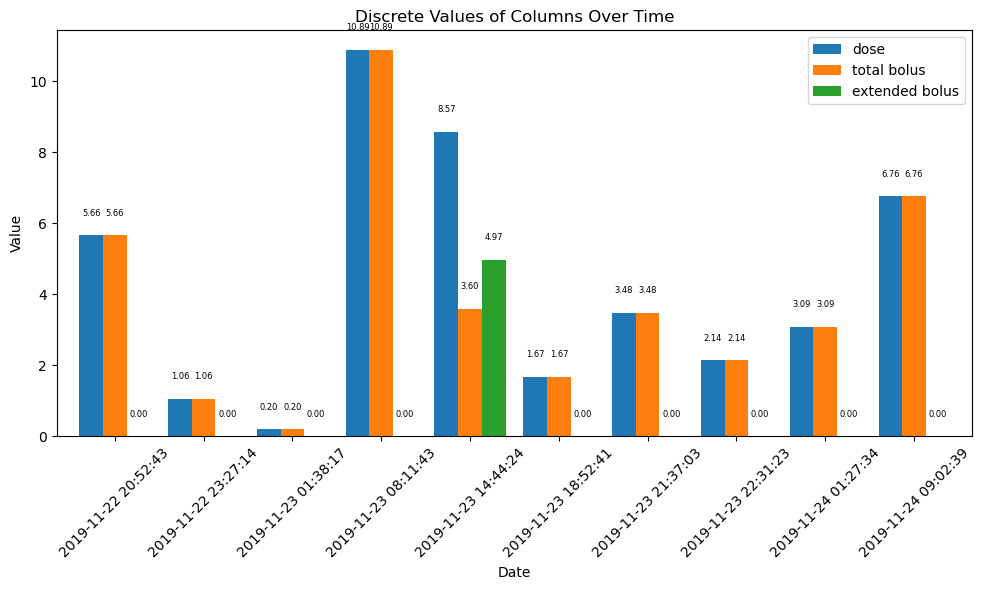

In [17]:
# Plot doses
subset_bolus_df = bolus_df[bolus_df['id'] == '1012'].iloc[20:30]
plt.figure(figsize=(10, 6))
subset_bolus_df.set_index('date', inplace=True)
ax = subset_bolus_df[['dose', 'total bolus', 'extended bolus']].plot(kind='bar', figsize=(10, 6), width=0.8)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Discrete Values of Columns Over Time')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to avoid clipping

for p in ax.patches:
    # Get the height of each bar
    height = p.get_height()
    
    # Add the text on top of the bar (the position of the text is adjusted to be above the bar)
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5,  # x-position, y-position (height + a little offset)
            f'{height:.2f}',  # Format the value as a float with 2 decimals
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment (to place the text on top of the bar)
            fontsize=6)

plt.show()

In [18]:
bolus_df['sum total extended'] = bolus_df['total bolus'] + bolus_df['extended bolus']

/opt/anaconda3/lib/python3.11/site-packages/xport/__init__.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [19]:
diff_dose = (bolus_df['sum total extended'] - bolus_df['dose']).sum()
mean_diff = (bolus_df['sum total extended'] - bolus_df['dose']).mean()
std_diff = (bolus_df['sum total extended'] - bolus_df['dose']).std()
print(f'Total diff {diff_dose}, mean {mean_diff} std {std_diff}')

Total diff -0.009560000000008367, mean -3.6308393467559314e-06 std 0.00010554621493100162


Conclusion based on this: the extended bolus rows are split into 1) dose: the total dose, 2) what they have ambigously named total bolus, which is actually the delivered bolus at that time, and 3) The extended bolus, which will be delivered at a later point in time. 

So, we need to figure out how long after that the extended bolus is delivered. We know that they are limited to: 'dual/square', 'square', or 'combination'. 

In [20]:
subset_bolus_df

,type,INSSTYPE,dose,unit,id,INSDVSRC,total bolus,extended bolus,duration
date,,,,,,,,,
2019-11-22 20:52:43,BOLUS INSULIN,normal,5.660,U,1012,Pump,5.66000,NaN,
2019-11-22 23:27:14,BOLUS INSULIN,normal,1.058,U,1012,Pump,1.05832,NaN,
2019-11-23 01:38:17,BOLUS INSULIN,normal,0.200,U,1012,Pump,0.20000,NaN,
2019-11-23 08:11:43,BOLUS INSULIN,normal,10.890,U,1012,Pump,10.89000,NaN,
2019-11-23 14:44:24,BOLUS INSULIN,dual/square,8.570,U,1012,Pump,3.59940,4.9706,P0Y0M0DT2H0M0S
2019-11-23 18:52:41,BOLUS INSULIN,normal,1.670,U,1012,Pump,1.67000,NaN,
2019-11-23 21:37:03,BOLUS INSULIN,normal,3.480,U,1012,Pump,3.48000,NaN,
2019-11-23 22:31:23,BOLUS INSULIN,normal,2.140,U,1012,Pump,2.14000,NaN,
2019-11-24 01:27:34,BOLUS INSULIN,normal,3.090,U,1012,Pump,3.09000,NaN,


In [21]:
def parse_duration(duration_str):
    if duration_str:  # Check if the string is not empty
        try:
            # Parse the duration using isodate
            return pd.to_timedelta(isodate.parse_duration(duration_str))
        except isodate.ISO8601Error:
            # Return NaN if parsing fails
            return np.nan
    else:
        # Return NaN for empty strings
        return np.nan

bolus_df['timedelta_duration'] = bolus_df['duration'].apply(lambda x: parse_duration(x))
bolus_df[bolus_df['timedelta_duration'].notna()].shape

/opt/anaconda3/lib/python3.11/site-packages/xport/__init__.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(2981, 12)

In [22]:
# Compare to extended boluses shape
count_col1 = bolus_df['extended bolus'].notna().sum()
count_col2 = bolus_df['timedelta_duration'].notna().sum()

# Count overlapping non-NaN values (where both columns are non-NaN in the same row)
count_overlap = ((bolus_df['extended bolus'].notna()) & (bolus_df['timedelta_duration'].notna())).sum()

# Print results
print(f"Non-NaN values in col1: {count_col1}")
print(f"Non-NaN values in col2: {count_col2}")
print(f"Overlapping non-NaN values in both col1 and col2: {count_overlap}")


Non-NaN values in col1: 2983
Non-NaN values in col2: 2981
Overlapping non-NaN values in both col1 and col2: 2981


In [23]:
unique_instype_count = bolus_df[bolus_df['extended bolus'].notna()]['INSSTYPE'].value_counts()
unique_instype_count

dual/square    2631
square          350
combination       2
Name: INSSTYPE, dtype: int64

In [24]:
unique_instype_count = bolus_df['INSSTYPE'].value_counts()
unique_instype_count

normal                        98456
                               9515
dual/square                    2631
automated                      1619
square                          351
combination                      48
standard/correction              46
standard                         27
automatic bolus/correction       26
dual (normal part)                1
dual (square part)                1
Name: INSSTYPE, dtype: int64

Great! only two samples dont have the time delta for the extended bolus. We see that the most common one is dual / square, second normla is square. Combination only happens twice. We observe that those two cases, it looks like the total bolus is delivered immediately (total bolus equals to the dose). Hence, we assume that these boluses are delivered instantly, because there is no duration specified also:

In [25]:
bolus_df[bolus_df['INSSTYPE'] == 'combination']

,type,INSSTYPE,dose,unit,date,id,INSDVSRC,total bolus,extended bolus,duration,sum total extended,timedelta_duration
771733,BOLUS INSULIN,combination,5.25,U,2020-04-12 19:05:00,1535,Pump,NaN,NaN,,NaN,NaT
1270328,BOLUS INSULIN,combination,7.50,U,2020-03-28 12:48:00,312,Pump,NaN,NaN,,NaN,NaT
1270333,BOLUS INSULIN,combination,8.25,U,2020-03-29 18:28:00,312,Pump,NaN,NaN,,NaN,NaT
1270336,BOLUS INSULIN,combination,9.70,U,2020-03-30 18:12:00,312,Pump,NaN,NaN,,NaN,NaT
1270354,BOLUS INSULIN,combination,8.05,U,2020-04-03 19:12:00,312,Pump,NaN,NaN,,NaN,NaT
1549425,BOLUS INSULIN,combination,6.00,U,2020-08-30 13:07:00,504,Pump,NaN,NaN,,NaN,NaT
1549426,BOLUS INSULIN,combination,9.35,U,2020-08-30 20:07:00,504,Pump,NaN,NaN,,NaN,NaT
1549429,BOLUS INSULIN,combination,10.00,U,2020-08-31 12:33:00,504,Pump,NaN,NaN,,NaN,NaT
1549435,BOLUS INSULIN,combination,12.40,U,2020-09-01 15:22:00,504,Pump,NaN,NaN,,NaN,NaT
1549437,BOLUS INSULIN,combination,3.20,U,2020-09-02 11:27:00,504,Pump,NaN,NaN,,NaN,NaT


In [26]:
bolus_df[bolus_df['INSSTYPE'] == 'square']

,type,INSSTYPE,dose,unit,date,id,INSDVSRC,total bolus,extended bolus,duration,sum total extended,timedelta_duration
35019,BOLUS INSULIN,square,5.000,U,2019-11-07 05:10:46,1014,Pump,NaN,5.00000,P0Y0M0DT2H0M0S,NaN,0 days 02:00:00
35020,BOLUS INSULIN,square,3.026,U,2019-11-07 07:13:17,1014,Pump,NaN,3.02632,P0Y0M0DT1H16M11S,NaN,0 days 01:16:11
35036,BOLUS INSULIN,square,6.000,U,2019-11-07 20:11:33,1014,Pump,NaN,6.00000,P0Y0M0DT2H0M0S,NaN,0 days 02:00:00
35104,BOLUS INSULIN,square,7.000,U,2019-11-10 19:56:46,1014,Pump,NaN,7.00000,P0Y0M0DT2H0M0S,NaN,0 days 02:00:00
35250,BOLUS INSULIN,square,7.000,U,2019-11-24 03:23:46,1014,Pump,NaN,7.00000,P0Y0M0DT2H0M0S,NaN,0 days 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2200737,BOLUS INSULIN,square,1.458,U,2019-11-30 20:31:26,985,Pump,NaN,1.45833,P0Y0M0DT0H24M44S,NaN,0 days 00:24:44
2200751,BOLUS INSULIN,square,0.250,U,2019-12-02 08:36:35,985,Pump,NaN,0.25000,P0Y0M0DT0H6M17S,NaN,0 days 00:06:17
2200753,BOLUS INSULIN,square,6.000,U,2019-12-02 10:25:55,985,Pump,NaN,6.00000,P0Y0M0DT0H45M0S,NaN,0 days 00:45:00
2200763,BOLUS INSULIN,square,1.880,U,2019-12-03 06:41:54,985,Pump,NaN,1.88000,P0Y0M0DT0H30M0S,NaN,0 days 00:30:00


Now we just need to understand how to treat the extended boluses for each type: 
- Combination: Treat as any other bolus (use total bolus if present, otherwise --> dose)
- Square: Bolus is delivered continously over a given duration. Indeed, we can see in these cases that the "total bolus" is nan, becuase nothing is delivered immediately (see below)
- Dual / square: Part of the bolus delivered immediately, the rest is delivered continously over the given timedelta_duration

In [27]:
bolus_df[bolus_df['INSSTYPE'] == 'square'].tail()

,type,INSSTYPE,dose,unit,date,id,INSDVSRC,total bolus,extended bolus,duration,sum total extended,timedelta_duration
2200737,BOLUS INSULIN,square,1.458,U,2019-11-30 20:31:26,985,Pump,NaN,1.45833,P0Y0M0DT0H24M44S,NaN,0 days 00:24:44
2200751,BOLUS INSULIN,square,0.250,U,2019-12-02 08:36:35,985,Pump,NaN,0.25000,P0Y0M0DT0H6M17S,NaN,0 days 00:06:17
2200753,BOLUS INSULIN,square,6.000,U,2019-12-02 10:25:55,985,Pump,NaN,6.00000,P0Y0M0DT0H45M0S,NaN,0 days 00:45:00
2200763,BOLUS INSULIN,square,1.880,U,2019-12-03 06:41:54,985,Pump,NaN,1.88000,P0Y0M0DT0H30M0S,NaN,0 days 00:30:00
2200774,BOLUS INSULIN,square,1.495,U,2019-12-03 20:46:56,985,Pump,NaN,1.49486,P0Y0M0DT0H20M58S,NaN,0 days 00:20:58


In [28]:
# Note that for the square boluses the "total bolus" is never 
bolus_df[bolus_df['INSSTYPE'] == 'square'].info()

<class 'xport.Dataset'>
Int64Index: 351 entries, 35019 to 2200774
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   type                351 non-null    object         
 1   INSSTYPE            351 non-null    object         
 2   dose                351 non-null    float64        
 3   unit                351 non-null    object         
 4   date                351 non-null    datetime64[ns] 
 5   id                  351 non-null    object         
 6   INSDVSRC            351 non-null    object         
 7   total bolus         0 non-null      float64        
 8   extended bolus      350 non-null    float64        
 9   duration            351 non-null    object         
 10  sum total extended  0 non-null      float64        
 11  timedelta_duration  350 non-null    timedelta64[ns]
dtypes: datetime64[ns](1), float64(4), object(6), timedelta64[ns](1)
memory usage: 35.6+ KB


Conclusion for bolus dose handling: 
- If dose available, use dose.
- Override doses with total bolus
- Create a new column with distributed extended boluses, by rounding the duration to 5-minute intervals, and creating new rows with the extended boluses
- Merge the two into a new column (IF ONE OF THEM IS NAN, IT SHOULD STILL WORK!)

In [29]:
bolus_df_final = bolus_df.copy()[['INSSTYPE', 'date', 'id', 'dose', 'total bolus', 'extended bolus', 'timedelta_duration']]
# Let values in total bolus override dose
bolus_df_final.loc[bolus_df_final['total bolus'].notna(), 'dose'] = bolus_df_final[bolus_df_final['total bolus'].notna()]['total bolus']
bolus_df_final.drop(columns=['total bolus'], inplace=True)
# Remove 0.0 values extended boluses --> all extended boluses now have duration
bolus_df_final['extended bolus'].replace(0.0, np.nan, inplace=True) 
# For the square boluses, "total bolus" is nan, but dose should be 0.0 because all of the bolus dose is extended 
bolus_df_final.loc[bolus_df_final['INSSTYPE'] == 'square', 'dose'] = 0.0

In [30]:
bolus_df_final[bolus_df_final['extended bolus'].notna()].head(3)#[bolus_df_final['INSSTYPE'] == 'square']

,INSSTYPE,date,id,dose,extended bolus,timedelta_duration
17933,dual/square,2019-11-23 14:44:24,1012,3.5994,4.97060,0 days 02:00:00
17972,dual/square,2019-11-28 13:18:53,1012,3.5607,0.72930,0 days 01:00:00
18018,dual/square,2019-12-04 21:22:14,1012,1.7088,0.12015,0 days 00:08:04


In [31]:
def split_duration(row):
    rounded_duration = round(row['timedelta_duration'] / pd.Timedelta(minutes=5)) * pd.Timedelta(minutes=5)
    num_intervals = rounded_duration // pd.Timedelta(minutes=5)
    if num_intervals < 1: 
        num_intervals = 1
    value_per_interval = row['extended bolus'] / num_intervals
    new_rows = []
    for i in range(int(num_intervals)):
        new_row = {
            'date': row['date'] + pd.Timedelta(minutes=5 * i),
            'extended bolus': value_per_interval,
            'timedelta_duration': pd.Timedelta(minutes=5),
            'id': row['id'],
        }
        new_rows.append(new_row)    
    return new_rows

# Apply the function to split durations and create new rows
extended_boluses = bolus_df_final[bolus_df_final['extended bolus'].notna()].copy()
new_rows = []
for _, row in extended_boluses.iterrows():
    new_rows.extend(split_duration(row))
extended_boluses = pd.DataFrame(new_rows)
extended_boluses.drop(columns=['timedelta_duration'], inplace=True)

In [32]:
# Original
bolus_df_final#[bolus_df_final['extended bolus'].notna()]

,INSSTYPE,date,id,dose,extended bolus,timedelta_duration
29,,2020-05-11 20:52:28,1,1.00,NaN,NaT
30,,2020-05-11 20:53:03,1,4.00,NaN,NaT
31,,2020-05-12 00:10:56,1,1.00,NaN,NaT
32,,2020-05-12 00:11:20,1,2.00,NaN,NaT
33,,2020-05-12 01:48:33,1,1.00,NaN,NaT
...,...,...,...,...,...,...
2217153,normal,2021-04-16 16:02:14,988,1.08,NaN,NaT
2217154,normal,2021-04-16 16:03:41,988,0.33,NaN,NaT
2217155,normal,2021-04-16 19:33:20,988,1.42,NaN,NaT
2217156,normal,2021-04-16 20:59:32,988,0.36,NaN,NaT


In [33]:
extended_boluses

,date,extended bolus,id
0,2019-11-23 14:44:24,0.207108,1012
1,2019-11-23 14:49:24,0.207108,1012
2,2019-11-23 14:54:24,0.207108,1012
3,2019-11-23 14:59:24,0.207108,1012
4,2019-11-23 15:04:24,0.207108,1012
...,...,...,...
45273,2021-04-07 12:19:53,0.528330,988
45274,2021-04-09 10:55:13,0.175500,988
45275,2021-04-09 11:00:13,0.175500,988
45276,2021-04-09 11:05:13,0.175500,988


In [34]:
# Merge boluses and extended boluses: 
columns = ['date', 'dose', 'id']
extended_boluses.rename(columns={'extended bolus': 'dose'}, inplace=True)
merged_bolus_df = pd.concat([bolus_df_final[columns], extended_boluses[columns]], ignore_index=True)
merged_bolus_df.sort_values(by='id', inplace=True)
merged_bolus_df

,date,dose,id
0,2020-05-11 20:52:28,1.0000,1
60,2020-06-01 22:18:33,8.0000,1
59,2020-06-01 15:18:15,6.0000,1
58,2020-06-01 09:23:15,6.0000,1
57,2020-05-31 23:01:56,4.0000,1
...,...,...,...
112610,2021-04-08 19:29:40,0.3000,988
112611,2021-04-08 19:34:54,1.6700,988
112612,2021-04-08 20:24:52,0.3800,988
112604,2021-04-08 14:37:07,0.4200,988


QUESTIONS BASAL RATES:
- How are extended basals registered? Do we need to explicitly account for suspend values?
- Are there consistent duplicates with flow rate / doses, or not?
- What is the difference between 'normal' 'dual/square' 'square'
 'automated' 'combination' 'standard/correction' 'standard'
 'automatic bolus/correction' 'dual (normal part)' 'dual (square part)'? 

In [35]:
basal_df = df_insulin[df_insulin['type'] != 'BOLUS INSULIN'][['INSSTYPE', 'dose', 'unit', 'date', 'id', 'INSDVSRC', 'duration']]
basal_df['duration'] = basal_df['duration'].apply(lambda x: parse_duration(x))
# We extract pump values for siplicity (basal doses injections are easy to hadle)
basal_df = basal_df[basal_df['INSDVSRC'] != 'Injections']
basal_df

,INSSTYPE,dose,unit,date,id,INSDVSRC,duration
113,,0.900,U/hr,2020-09-22 00:00:00,1000,,0 days 02:00:00
114,,0.700,U/hr,2020-09-22 02:00:00,1000,,0 days 04:00:00
115,,1.050,U/hr,2020-09-22 06:00:00,1000,,0 days 04:00:00
116,,0.900,U/hr,2020-09-22 10:00:00,1000,,0 days 04:00:00
117,,1.100,U/hr,2020-09-22 14:00:00,1000,,0 days 05:00:00
...,...,...,...,...,...,...,...
2216816,temp,0.008,U,2021-04-16 23:35:38,988,Pump,0 days 00:05:01
2216817,temp,0.015,U,2021-04-16 23:40:39,988,Pump,0 days 00:05:01
2216818,temp,0.029,U,2021-04-16 23:45:40,988,Pump,0 days 00:05:02
2216819,temp,0.027,U,2021-04-16 23:50:42,988,Pump,0 days 00:04:59


In [36]:
basal_df['id'].unique()[:8]

array(['1000', '1004', '1010', '1012', '1013', '1014', '1016', '1020'],
      dtype=object)

In [37]:
basal_df['INSDVSRC'].unique()

array(['', 'Pump'], dtype=object)

In [38]:
basal_df['unit'].unique()

array(['U/hr', 'U'], dtype=object)

In [39]:
basal_df['INSSTYPE'].unique()

array(['', 'scheduled', 'temp', 'suspend', 'automated'], dtype=object)

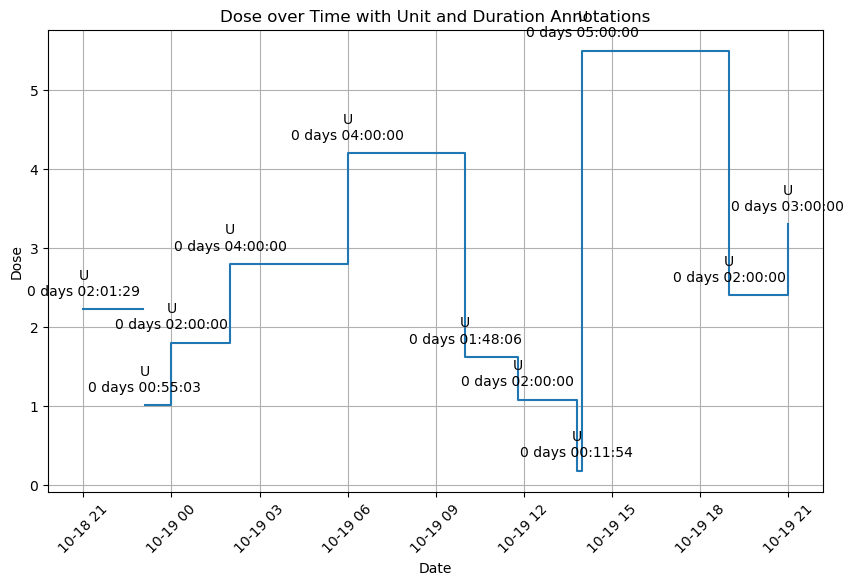

In [40]:
# Plot basals
subset_basal_df = basal_df[basal_df['id'] == '1000'].tail(12*1)
plt.figure(figsize=(10, 6))
subset_basal_df.set_index('date', inplace=True)

plt.step(subset_basal_df.index, subset_basal_df['dose'], where='post', label='Dose')

# Annotate unit and duration at each step
for i, row in subset_basal_df.iterrows():
    plt.annotate(f"{row['unit']}\n{row['duration']}", 
                 (i, row['dose']), 
                 textcoords="offset points", 
                 xytext=(0, 10),  # Offset slightly above the point
                 ha='center')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Dose')
plt.title('Dose over Time with Unit and Duration Annotations')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

In [41]:
# Questions:
# Do the same patients have U or U/hr?
# Does U/hr always come with a duration? 
# Does U/hr with duration always match with the next value? 
# How does the suspend work, is it reflected in the values? 

In [48]:
# Duration analysis: We see that duration is almost always present in the basals! 
basal_df.count()

Variable
INSSTYPE    2102072
dose        2074189
unit        2102072
date        2102072
id          2102072
INSDVSRC    2102072
duration    2102070
end date    2102070
dtype: int64

In [43]:
# We see here that the dose is nan when there is suspend! 
basal_df[basal_df['duration'].isna()]

,INSSTYPE,dose,unit,date,id,INSDVSRC,duration
721814,,1.45,U/hr,2020-11-18 09:00:00,1501,,NaT
721859,,NaN,U,2020-11-18 09:00:00,1501,Pump,NaT


In [45]:
# How do the U values differ from the U/hr values? how are the sizes? Make sure that its correctly noted
u_values = basal_df[basal_df['unit'] == 'U']['dose'].values
u_hr_values = basal_df[basal_df['unit'] == 'U/hr']['dose'].values

# Check if the filtered arrays are empty to avoid errors
if u_values.size > 0:
    print(f'U: mean {np.nanmean(u_values)} std {np.nanstd(u_values)}')
else:
    print('No values found for U')

if u_hr_values.size > 0:
    print(f'U/hr: mean {np.nanmean(u_hr_values)} std {np.nanstd(u_hr_values)}')
else:
    print('No values found for U/hr')


U: mean 0.2174016318675067 std 1.1230945951627698
U/hr: mean 0.9392870486128052 std 0.806519463562872


In [47]:
basal_df['end date'] = basal_df['date'] + basal_df['duration']

In [63]:
# Does duration always match with the next value? 
subjects = basal_df['id'].unique()[:5]

for subject in subjects:
    subset_basal_df = basal_df[basal_df['id'] == subject]
    time_diff = (subset_basal_df['date'] - subset_basal_df['end date'].shift()).dt.total_seconds() / 60
    total_time = time_diff.sum()
    print(f"TOTAL SUM for subject {subject}: {total_time} minutes")

TOTAL SUM for subject 1000: -39189.33333333333 minutes
TOTAL SUM for subject 1004: -40310.566666666666 minutes
TOTAL SUM for subject 1010: -40320.0 minutes
TOTAL SUM for subject 1012: -40320.0 minutes
TOTAL SUM for subject 1013: -40320.0 minutes
TOTAL SUM for subject 1014: -40320.0 minutes
TOTAL SUM for subject 1016: -17618.13333333334 minutes
TOTAL SUM for subject 1020: -40320.0 minutes
TOTAL SUM for subject 1021: -40320.0 minutes
TOTAL SUM for subject 1022: -40324.816666666666 minutes


In [52]:
subset_basal_df

,INSSTYPE,dose,unit,date,id,INSDVSRC,duration,end date
51455,scheduled,1.100,U/hr,2019-11-15 00:00:00,1022,,0 days 02:00:00,2019-11-15 02:00:00
51456,scheduled,0.900,U/hr,2019-11-15 02:00:00,1022,,0 days 01:00:00,2019-11-15 03:00:00
51457,scheduled,0.900,U/hr,2019-11-15 03:00:00,1022,,0 days 05:00:00,2019-11-15 08:00:00
51458,scheduled,1.150,U/hr,2019-11-15 08:00:00,1022,,0 days 01:30:00,2019-11-15 09:30:00
51459,scheduled,1.350,U/hr,2019-11-15 09:30:00,1022,,0 days 04:30:00,2019-11-15 14:00:00
...,...,...,...,...,...,...,...,...
59836,automated,0.050,U,2019-12-12 23:39:49,1022,Pump,0 days 00:05:01,2019-12-12 23:44:50
59837,automated,0.050,U,2019-12-12 23:44:50,1022,Pump,0 days 00:05:00,2019-12-12 23:49:50
59838,automated,0.074,U,2019-12-12 23:49:50,1022,Pump,0 days 00:04:57,2019-12-12 23:54:47
59839,automated,0.075,U,2019-12-12 23:54:47,1022,Pump,0 days 00:05:00,2019-12-12 23:59:47


In [65]:
len(((subset_basal_df['date'] - subset_basal_df['end date'].shift()).dt.total_seconds() / 60))

8386

In [68]:
subset_basal_df[subset_basal_df['diff'] < 0]

,INSSTYPE,dose,unit,date,id,INSDVSRC,duration,end date,diff
55648,scheduled,2.2,U,2019-11-15,1022,Pump,0 days 02:00:00,2019-11-15 02:00:00,-40324.816667


In [69]:
basal_df

,INSSTYPE,dose,unit,date,id,INSDVSRC,duration,end date
113,,0.900,U/hr,2020-09-22 00:00:00,1000,,0 days 02:00:00,2020-09-22 02:00:00
114,,0.700,U/hr,2020-09-22 02:00:00,1000,,0 days 04:00:00,2020-09-22 06:00:00
115,,1.050,U/hr,2020-09-22 06:00:00,1000,,0 days 04:00:00,2020-09-22 10:00:00
116,,0.900,U/hr,2020-09-22 10:00:00,1000,,0 days 04:00:00,2020-09-22 14:00:00
117,,1.100,U/hr,2020-09-22 14:00:00,1000,,0 days 05:00:00,2020-09-22 19:00:00
...,...,...,...,...,...,...,...,...
2216816,temp,0.008,U,2021-04-16 23:35:38,988,Pump,0 days 00:05:01,2021-04-16 23:40:39
2216817,temp,0.015,U,2021-04-16 23:40:39,988,Pump,0 days 00:05:01,2021-04-16 23:45:40
2216818,temp,0.029,U,2021-04-16 23:45:40,988,Pump,0 days 00:05:02,2021-04-16 23:50:42
2216819,temp,0.027,U,2021-04-16 23:50:42,988,Pump,0 days 00:04:59,2021-04-16 23:55:41


In [77]:
no_time_rows = subset_basal_df[subset_basal_df['date'].dt.time == pd.to_datetime('00:00:00').time()]
no_time_rows.head(11)

,INSSTYPE,dose,unit,date,id,INSDVSRC,duration,end date,diff
51455,scheduled,1.10,U/hr,2019-11-15,1022,,0 days 02:00:00,2019-11-15 02:00:00,NaN
51936,scheduled,1.10,U/hr,2019-11-18,1022,,0 days 02:00:00,2019-11-18 02:00:00,0.000000
52900,scheduled,1.10,U/hr,2019-11-23,1022,,0 days 02:00:00,2019-11-23 02:00:00,0.000000
54416,scheduled,1.10,U/hr,2019-12-01,1022,,0 days 02:00:00,2019-12-01 02:00:00,0.000000
54429,scheduled,1.10,U/hr,2019-12-02,1022,,0 days 02:00:00,2019-12-02 02:00:00,0.000000
55420,temp,0.66,U/hr,2019-12-08,1022,,0 days 02:00:00,2019-12-08 02:00:00,0.000000
55430,scheduled,0.90,U/hr,2019-12-09,1022,,0 days 02:00:00,2019-12-09 02:00:00,0.000000
55437,scheduled,0.90,U/hr,2019-12-10,1022,,0 days 02:00:00,2019-12-10 02:00:00,0.000000
55445,temp,0.54,U/hr,2019-12-11,1022,,0 days 00:42:28,2019-12-11 00:42:28,0.000000
55648,scheduled,2.20,U,2019-11-15,1022,Pump,0 days 02:00:00,2019-11-15 02:00:00,-40324.816667


Observing above that the strange diffs might be due to going over to U instead of U/hr. We should probably analyze them separately and ensure that they are sorted!

/opt/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


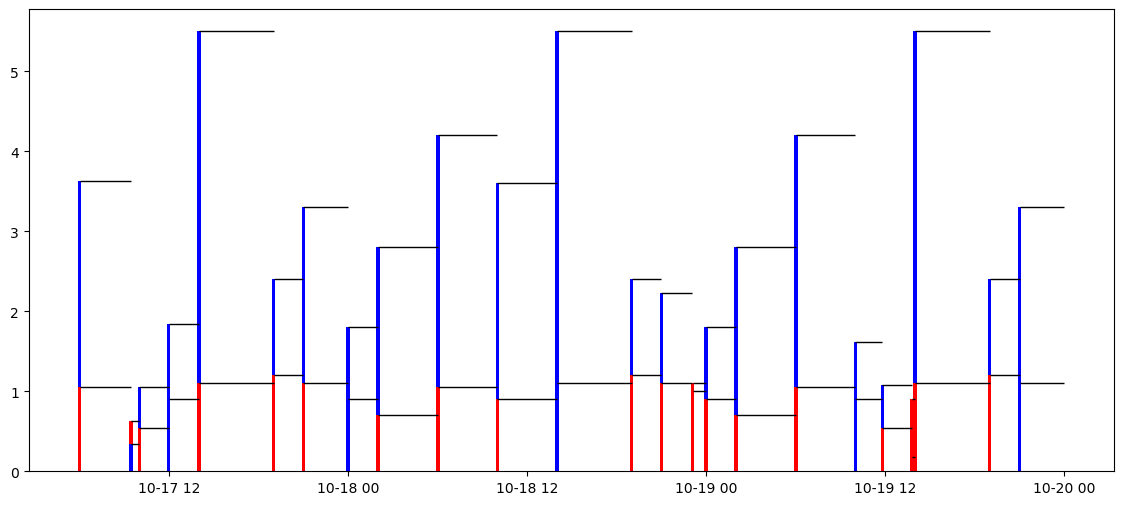

In [131]:
subset_basal_df = basal_df[basal_df['id'] == '1000']
subset_basal_df.sort_values(by=['date'], inplace=True)
subset_basal_df = subset_basal_df.tail(50)

x = subset_basal_df.date
y = subset_basal_df.dose
units = subset_basal_df.unit  # Assuming unit is either 'U' or 'U/hr'
colors = {'U': 'blue', 'U/hr': 'red'}

plt.figure(figsize=(14, 6)) 
ax = plt.subplot(111)
for i, row in subset_basal_df.iterrows():
    ax.bar(row['date'], row['dose'], width=0.01, color=colors[row['unit']])
    ax.hlines(y=row['dose'], xmin=row['date'], xmax=row['end date'], color='black', linewidth=1)

#ax.bar(x, y, width=0.003)
ax.xaxis_date()

plt.show()

In [134]:
# From the plot above, is seems like each U has a corresponding U/hr, lets check: 
subjects = basal_df['id'].unique()

for subject in subjects:
    subset_basal_df = basal_df[basal_df['id'] == subject]
    num_u = subset_basal_df[subset_basal_df['unit'] == 'U'].shape[0]
    num_u_hr = subset_basal_df[subset_basal_df['unit'] == 'U/hr'].shape[0]
    print(f"subject {subject}: diff shape={num_u - num_u_hr}")

subject 1000: diff shape=0
subject 1004: diff shape=0
subject 1010: diff shape=0
subject 1012: diff shape=0
subject 1013: diff shape=0
subject 1014: diff shape=0
subject 1016: diff shape=0
subject 1020: diff shape=0
subject 1021: diff shape=0
subject 1022: diff shape=0
subject 1033: diff shape=0
subject 1039: diff shape=0
subject 104: diff shape=0
subject 1043: diff shape=0
subject 1046: diff shape=0
subject 1050: diff shape=0
subject 1051: diff shape=0
subject 1067: diff shape=0
subject 107: diff shape=0
subject 1072: diff shape=0
subject 1076: diff shape=0
subject 1077: diff shape=0
subject 1082: diff shape=0
subject 1090: diff shape=0
subject 11: diff shape=0
subject 1100: diff shape=0
subject 1103: diff shape=0
subject 1107: diff shape=0
subject 1110: diff shape=0
subject 1119: diff shape=0
subject 1120: diff shape=0
subject 1121: diff shape=0
subject 1123: diff shape=0
subject 1127: diff shape=0
subject 1138: diff shape=0
subject 1139: diff shape=0
subject 114: diff shape=0
subjec

In [224]:
# We see that a U/hr is always accompanied with a U. Now we need to understand whether the durations and dates perfectly match:
# We also need to understand how long the durations are - are they so short that we should use duration instead of flow rate? 
u_hr_df = basal_df[basal_df['unit'] == 'U/hr'].reset_index()
u_df = basal_df[basal_df['unit'] == 'U'].reset_index()
columns_to_compare = ['date', 'id', 'duration']
are_equal = u_df[columns_to_compare].equals(u_hr_df[columns_to_compare])

if are_equal:
    print("The selected columns are the same in both DataFrames.")
else:
    print("The selected columns are different between the DataFrames.")

print(u_df['duration'].mean())
print(u_df['duration'].std())
print(u_df['duration'].max())

The selected columns are the same in both DataFrames.
0 days 00:15:08.890782894
0 days 01:24:26.916842700
28 days 19:41:01


In [149]:
u_df[u_df['duration'] > pd.Timedelta(days=3)]

,index,INSSTYPE,dose,unit,date,id,INSDVSRC,duration,end date
40542,84174,,186.130,U,2021-01-18 05:00:00,1046,Pump,11 days 01:54:00,2021-01-29 06:54:00
201384,419121,scheduled,160.787,U,2020-05-06 13:29:31,1283,Pump,10 days 07:21:53,2020-05-16 20:51:24
473832,993254,scheduled,59.463,U,2020-09-28 10:42:33,1649,Pump,3 days 00:04:33,2020-10-01 10:47:06
606169,1272056,scheduled,300.742,U,2020-03-10 07:02:41,313,Pump,19 days 06:40:49,2020-03-29 13:43:30
611005,1280458,scheduled,318.174,U,2019-03-01 12:40:42,317,Pump,28 days 19:41:01,2019-03-30 08:21:43
737285,1549321,scheduled,348.215,U,2020-08-29 06:30:00,504,Pump,19 days 08:17:11,2020-09-17 14:47:11
770086,1618145,scheduled,336.300,U,2021-01-13 06:00:00,556,Pump,14 days 18:00:00,2021-01-28 00:00:00
996169,2096785,scheduled,64.760,U,2020-10-05 06:02:06,897,Pump,7 days 11:53:24,2020-10-12 17:55:30
1016724,2140057,scheduled,149.932,U,2020-08-27 06:00:00,95,Pump,5 days 16:18:07,2020-09-01 22:18:07


In [ ]:
# What we see is that the dose can sometimes be enormous for long durations

In [190]:
# Now we want to understand if the dose is the same as flow multiplied by duration
u_df['calculated_dose'] = u_df['dose'] / (u_hr_df['duration'].dt.total_seconds() / 3600) # Divide by the number of hours
u_df['u_hr_dose'] = u_hr_df['dose']
u_df['diff_dose'] = u_hr_df['dose'] - u_df['calculated_dose']
u_df[u_df['diff_dose'].abs() > 0.2].shape

(282, 13)

In [185]:
u_df[u_df['diff_dose'].abs() > 0.01]
print(u_df[u_df['diff_dose'].abs() > 0.2].shape)
print(u_df['diff_dose'].max())
print(u_df[u_df['diff_dose'].abs() > 0.001]['duration'].max())
print(u_df[u_df['diff_dose'].abs() > 0.001]['INSSTYPE'].unique())
print(u_df['INSSTYPE'].unique())

(282, 13)
1.74
0 days 00:30:00
['temp' 'scheduled' 'automated' '']
['' 'scheduled' 'temp' 'suspend' 'automated']


In [163]:
# 4691 / 1051036 = 0,4% of the basal samples have values that differ using the U and the U/hr conversion
# 664 / 1051036 = 0,06% of the basal samples have values that differ using the U and the U/hr conversion (threshold 0.1U)
# 282 / 1051036 = 0,03% of the basal samples have values that differ using the U and the U/hr conversion (threshold 0.2U)
# We see that in the cases where the diff_dose absolute values is larger than 0.001, the max duration is 30 minutes. 
# However, there is no way of knowing whether the U or flow is more relevant. We have to consider it negligable
u_df.shape

(1051036, 13)

In [180]:
u_df[u_df['INSSTYPE'] == 'suspend'].count()

Variable
index              14457
INSSTYPE           14457
dose                 517
unit               14457
date               14457
id                 14457
INSDVSRC           14457
duration           14457
end date           14457
calculated_dose      517
is_equal           14457
u_hr_dose            517
diff_dose            517
dtype: int64

In [207]:
basal_df[basal_df['INSSTYPE'] == 'suspend']['dose'].unique()

array([nan,  0.])

In [218]:
# Lastly, choosing U/hr - are the end dates always matching with the next start date?
# And are the nan suspend values nan? 
subjects = basal_df['id'].unique()

total_samples = 0
time_diff_samples = 0
neg_time_diff_samples = 0
pos_time_diff_samples = 0
for subject in subjects:
    subset_basal_df = basal_df[basal_df['id'] == subject]
    subset_basal_df = subset_basal_df[subset_basal_df['unit'] == 'U/hr']
    subset_basal_df.sort_values(by='date', inplace=True)
    subset_basal_df['time diff'] = (subset_basal_df['date'] - subset_basal_df['end date'].shift()).dt.total_seconds() / 60
    total_time = time_diff.sum()
    #print(f"TOTAL SUM for subject {subject}: {total_time} minutes")
    total_samples += subset_basal_df.shape[0]
    time_diff_samples += subset_basal_df[subset_basal_df['time diff'].abs() > 0.0].shape[0]
    neg_time_diff_samples += subset_basal_df[subset_basal_df['time diff'] < 0.0].shape[0]
    pos_time_diff_samples += subset_basal_df[subset_basal_df['time diff'] > 0.0].shape[0]


print(f'Total samples: {total_samples}, samples where time diff is ambigous: {time_diff_samples}. {time_diff_samples/total_samples*100:.3f}%')
print(f'Pos diff {pos_time_diff_samples/total_samples*100:.3f}%, neg diff {neg_time_diff_samples/total_samples*100:.3f}%')
#subset_basal_df[subset_basal_df['time diff'].abs() > 0.0]

Total samples: 1051036, samples where time diff is ambigous: 1293. 0.123%
Pos diff 0.044, neg diff 0.079


Conclusions basal:

- If the basal type is injection, the solution is simpler because we should simply use the dose. In our dataset, we could have a separate column basal_injections if there are any injections in our filtered subjects (we filter out MDI users)
- Filtering (removing injections) based on unit U or U/hr gives the exact same dates and durations - so we can choose one of them. We choose the U values, and use those to distribute insulin throughout. **NOTE: When we compute the U/hr based on the U doses, most of the values are close to equal to the corresponding U/hr value. However, there are 0,03% of the samples where the difference is larger than 0,2 U/hr. There is no place in the documentation describing how to interpret these differences. Hence, I have considered this ambiouity as negligable.**
- Some of the type suspend values are nan, and we change those to 0.0 because we know that they are suspended and that there is no insulin delivery
- **NOTE! There are some cases where the dates + duration either overlap with the next values or there is a gap in between. The gaps we handle with nan values. If there is an overlap, we will use both overlapping values and use the sum of the basal injection distribution. As far as I can see, no documentation on how to handle this situation, and it only appears in 0.01% of the samples (have searched in the .html + the three documentation pdfs).**
   - One theory is that some of these examples are simply logging errors, while other might be because of time zone shifting! We have not handled time zone shifts
- Basal rates should be distributed as following: Similar to the extended boluses, we add new rows throughout 5 minute intervals. 

In [233]:
# Final handling of basal rates
# 1) use the U dfs, and make suspend values 0.0
final_basal_df = u_df.copy()
final_basal_df.loc[final_basal_df['INSSTYPE'] == 'suspend', 'dose'] = final_basal_df.loc[u_df['INSSTYPE'] == 'suspend', 'dose'].replace(np.nan, 0.0)

# 2) We drop the two rows where dose is nan
final_basal_df = final_basal_df[final_basal_df['dose'].notna()]

# 3) round duration to nearest 5 minutes, and create new rows to distribute the given dose throughout that duration
def split_duration(row):
    rounded_duration = round(row['duration'] / pd.Timedelta(minutes=5)) * pd.Timedelta(minutes=5)
    num_intervals = rounded_duration // pd.Timedelta(minutes=5)
    if num_intervals < 1: 
        num_intervals = 1
    value_per_interval = row['dose'] / num_intervals
    new_rows = []
    for i in range(int(num_intervals)):
        new_row = {
            'date': row['date'] + pd.Timedelta(minutes=5 * i),
            'dose': value_per_interval,
            'duration': pd.Timedelta(minutes=5),
            'id': row['id'],
        }
        new_rows.append(new_row)    
    return new_rows

# Apply the function to split durations and create new rows
new_rows = []
for _, row in final_basal_df.iterrows():
    new_rows.extend(split_duration(row))
final_basal_df = pd.DataFrame(new_rows)
final_basal_df.drop(columns=['duration'], inplace=True)

print(final_basal_df.count())
final_basal_df

date    3193396
dose    3193396
id      3193396
dtype: int64


,date,dose,id
0,2020-09-22 00:00:00,0.075,1000
1,2020-09-22 00:05:00,0.075,1000
2,2020-09-22 00:10:00,0.075,1000
3,2020-09-22 00:15:00,0.075,1000
4,2020-09-22 00:20:00,0.075,1000
...,...,...,...
3193391,2021-04-16 23:35:38,0.008,988
3193392,2021-04-16 23:40:39,0.015,988
3193393,2021-04-16 23:45:40,0.029,988
3193394,2021-04-16 23:50:42,0.027,988


The final basal dataframe is there, but note that above the unit is in U and not U/hr. So the values should be multiplied: 

In [234]:
final_basal_df['basal rate'] = final_basal_df['dose'] * 12
final_basal_df

,date,dose,id,basal rate
0,2020-09-22 00:00:00,0.075,1000,0.900
1,2020-09-22 00:05:00,0.075,1000,0.900
2,2020-09-22 00:10:00,0.075,1000,0.900
3,2020-09-22 00:15:00,0.075,1000,0.900
4,2020-09-22 00:20:00,0.075,1000,0.900
...,...,...,...,...
3193391,2021-04-16 23:35:38,0.008,988,0.096
3193392,2021-04-16 23:40:39,0.015,988,0.180
3193393,2021-04-16 23:45:40,0.029,988,0.348
3193394,2021-04-16 23:50:42,0.027,988,0.324


## SUMMARY OF FIXES:

- Fixing date times processing
- Code for fetching the insulin type for each individual
- Correct handling of workouts, choosing only one data column, using duration instead of forward filling
- Correct handling of bolus doses, with respect to extended boluses
- Correct handling of basal rates, with respect to handling suspended nan values and overlapping / gaps in duration

## REMAINING WORK:

- FA (heartrate) and VS (steps) are not inspected
- Time zone shifts are not yet found, analyzed, and accounted for
- Keep going systematically through the rest of the dfs
    - Add steps data to the processed dataset
    - Validate that the carbohydrates are handled correctly
- When the new data is processed, validate that:
    - The original sum of carbs / boluses / basal injections should be the same
    - 5-minute intervals consistency for each subject
    - Sorted for each subject
    - CGM / heartrate... values count, mean, and std should be the same as the original one
    - Check that all of the subjects have data for all of the features
- Create a new notebook and go through T1DexiP as thrououghly as we have done here 